# Projet 5MA-OSI : Transfert d'organes en domino sous incertitudes

<div style="text-align: right;">
Julie THOMAS
    
<div style="text-align: right;">
Mathias LOMMEL

<div style="text-align: right;">
5MA - 2024

# Introduction

Malgré l'augmentation croissante du nombre de transplantations d'organes effectuées chaque année (environ 6000 en 2017 dont 3782 transplantations de reins), la demande reste en perpétuelle augmentation. Ainsi 6000 organes, dont 3782 reins, ont été transplantés en 2017, mais il y avait encore 24000 personnes en attente d'un organe la même année. Les organes transplantés peuvent provenir d'un donneur décédé ou, dans le cas des reins et du foie, d'un donneur vivant consentant, le plus souvent membre de la famille du patient. Hélas, même si un proche accepte de prendre ce risque pour sa santé, il ne sera pas forcément compatible avec le patient. Pour cette raison, les pratiques médicales et les législations évoluent dans de nombreux pays afin de permettre la mise en place d'un programme d'échange de dons d'organes.

L'exemple le plus simple d'échange de don d'organes est celui où deux patients $P_1$ et $P_2$ sont accompagnés de donneurs $D_1$ et $D_2$. Les patients sont supposés incompatibles avec les donneurs qui les accompagnent, mais on suppose que $D_1$ est compatible avec $P_2$ et $D_2$ avec $P_1$. Il est alors possible de transplanter un organe de $D_1$ vers $P_2$ et de $D_2$ vers $P_1$ avec le consentement de tous et en suivant la procédure légale.

Plus généralement, un cycle d'échange d'organes associe $k$ paires de patient-donneur $(P_{i_1},D_{i_1}), \dots, (P_{i_k},D_{i_k})$ de sorte que $D_{i_l}$ donne à $P_{i_{l+1}}$ pour $l=1,\dots,k-1$ et $D_{i_k}$ donne à $P_{i_1}$.
Par ailleurs, le point essentiel est que les transferts soient tous réalisés en même temps et dans le même hôpital pour éviter qu'une rétractation de dernière minute ne lèse un patient et son donneur, et que les patients et donneurs venus ensemble et leur famille puissent se soutenir émotionnellement durant l'hospitalisation. 
Pour cette raison, le nombre d'échanges prenant place au sein d'un même cycle est nécessairement limité. En pratique, l'organisation d'un cycle de trois paires est déjà une épreuve pour le personnel d'un hôpital, et le plus grand cycle ayant jamais eu lieu a a impliqué six patients et donneurs.

Dans ce projet, nous prendrons le point de vue de l'organisme national responsable de la gestion du programme d'échange d'organes. 
À chaque phase d'échange, l'objectif de cet organisme est de choisir un ensemble de cycles d'échanges entre paires compatibles afin de maximiser le nombre de patients recevant un organe. Dans certains cas, on peut aussi donner une priorité à certains patients en fonction de la gravité de leur état ou de la durée de leur attente. 
Pour cela, on pourra attribuer des poids différents à chaque patient et maximiser la somme des poids des patients recevant un organe. 

# Étude du problème déterministe

## Jeux de données

Nos tests seront en partie basés sur les jeux de données de la [PrefLib](https://www.preflib.org/dataset/00036). Ces jeux de données ne correspondent pas à des programmes d'échanges d'organes réels pour des raisons de confidentialité, mais ils reproduisent la structure des données réelles. 
Ils sont constitués d'informations individuelles et d'un graphe de compatibilité. Chaque fichier .wmd décrit un graphe de compatibilité orienté, $G=(V,A)$, où chaque sommet de $V$ représente une paire donneur-malade et où un arc entre deux paires $(P_k,D_k)$ et $(P_l,D_l)$ signifie que $D_k$ est compatible avec $P_l$. La compatibilité est obtenue à partir des données biologiques individuelles (e.g., les groupes sanguins) et d'un _test croisé_ lors duquel des biologistes mettent en présence des tissus d'un malade et d'un donneur supposé. Chaque fichier est composé comme suit :  
- les 11 premières lignes contiennent diverses informations sur le fichier, dont le nombre de sommets ($n$) et le nombre d'arcs ($m$),
- les $n$ lignes suivantes nomment les sommets (un sommet par paire),
- les $m$ lignes restantes contiennent les arcs du graphe et le poids de chaque arc. Le poids de chaque arc indique l'urgence de la situation du malade de la paire destination. 

Nous utiliserons une fonction permettant de lire les fichiers .wmd et retournant un graphe de compatibilité pondéré par les poids de chaque patient.

### Importation des librairies

In [22]:
# Importation des packages utiles
# import Pkg; 
# Pkg.add(["MetaGraphs"]);
# Pkg.add(["NBInclude"]);
# Pkg.add(["JuMP"]);
# Pkg.add("SimpleWeightedGraphs");
# Pkg.add("Graphs");
# Pkg.add("HiGHS");
# Pkg.add("Distributions");
# Pkg.add("Cbc");
# Pkg.add("BenchmarkProfiles");
# Pkg.add("Plots");
# Pkg.add("DataFrames")

In [1]:
# Inclusion des librairies
using Random, MetaGraphs, SimpleWeightedGraphs, Graphs, JuMP, HiGHS, DelimitedFiles, Distributions, Cbc, Plots, DataFrames;

### Fonction créant la liste des arcs $A$, et les prédécesseurs/successeurs de chaque noeud

Tout d'abord, nous allons utiliser la fonction permettant la lecture des fichiers .wmd. Cette fonction renvoie le graphe associé, accompagné de sa matrice de poids.

In [2]:
using NBInclude
@nbinclude("readfile/KEP_readfile.ipynb")

Fonction de lecture des fichiers .wmd importée avec succès.


Nous pouvons ensuite définir une seconde fonction, qui, à partir d'un graphe donné, détermine la liste de ses arcs, ainsi que les listes des prédécesseurs/successeurs de chaque sommet de celui-ci.

In [3]:
function compute_A(G)
    """
    Crée la matrice des arcs pour un graphe G donné, ainsi que les listes des prédecesseurs/successeurs de chaque noeud.

    Entrées : 
        - G : SimpleDiGraph - Graphe d'intérêt
    
    Sorties : 
        - n     : Integer - Nombre de sommets
        - A     : Array   - Liste des arcs 
        - preds : Array   - Liste des prédécesseurs de chaque sommet
        - succ  : Array   - Liste des successeurs de chaque sommet
    """
    # Initialisations
    n = nv(G)
    A = [];
    
    # Création des listes de prédécesseurs/successeurs pour chaque sommet
    preds=[[] for i in range(1,n)]
    succ=[[] for i in range(1,n)]
    
    # Pour chaque arc de G, on stocke l'arc dans A, et on ajoute les prédécesseurs/successeurs dans les listes
    for e in edges(G)
        # Ajout de l'arc à A
        push!(A,(e.src,e.dst));
    
        # On remplit les listes des prédécesseurs/successeurs
        push!(preds[e.dst],e.src)
        push!(succ[e.src],e.dst)
    end
    
    return n,A,preds,succ
end

compute_A (generic function with 1 method)

Enfin, en utilisant les deux fonctions précédentes, nous définissons une ultime méthode, permettant d'importer un ou plusieurs graphe(s) via leur identifiant ("001", "031",...). Chaque graphe sera caractérisé par ses paramètres (n,A,W,preds,succ), et la méthode renvoie le vecteur des graphes souhaités.

In [4]:
function load_graphs(index_list)
    """
    Fonction permettant d'extraire les propriétés d'une liste de graphe, donnés par leur indice.
    
    Entrée : 
        - index_list : Array - Liste des indices des graphes à importer
    
    Sortie :
        - graphs : Array - Liste des graphes souhaités
    
    """
    # Initialisation du vecteur des graphes
    graphs = []
    # Pour chaque indice souhaité
    for index in index_list
        # On importe le graphe
        G,W = read_wmd_file("Data_KEP/KEP_"*index*".wmd");
        # On calcule n, A, preds et succ
        n,A,preds,succ = compute_A(G);
        # Création du graphe
        graph = [n,A,W,preds,succ]
        # Ajout du graphe dans la liste
        push!(graphs,graph)
    end
    
    return graphs
end

load_graphs (generic function with 1 method)

## Formulations compactes

Dans le cadre du TD/TP du cours de Recherche Opérationnelle de 4e année, nous avons codé trois formulations PLNE liées au problème de transplantation en dominos, à savoir :
- celle sans contrainte sur la longueur des cycles : ```compact_cycle_infini```
- celle avec des cycles de taille 2 : ```compact_cycle_2```
- celle avec la décomposition par hôpital pour des cycles de taille 2 à 6 : ```compact_cycle_K```

Nous allons donc ajouter ces 3 formulations via 3 fonctions différentes, prenant à chaque fois un graphe de compatibilité et éventuellement d'autres paramètres en entrée, et retournant le modèle résolu, avec sa valeur optimale. *Voir ```Formulations_Compactes.ipynb```*.

In [5]:
@nbinclude("Formulations_compactes/Formulations_Compactes.ipynb")

Formulations compactes importées avec succès.


### Sans contrainte de longueur

Détails de la formulation : 
- Variables : 
$ \forall (i,j) \in A, x_{(i,j)} = \begin{cases} 1 & \text{ si le donneur du couple i donne au receveur du couple j} \\ 0 & \text{sinon} \end{cases}
$
- Contraintes : 
    - Tous les couples peuvent donner, au plus, une seule fois ($C_1$)
    - Si un couple donne à un autre, alors il doit aussi recevoir ($C_2$)
- Modèle : 
$$
\begin{align}
max &\sum_{a \in A} x_a.w_a \\
&\forall i \in V, \sum_{j \in Succ(i)} x_{(i,j)} \le 1 &(C_1)\\
&\forall i \in V, \sum_{j \in Succ(i)} x_{(i,j)} = \sum_{j \in Preds(i)} x_{(j,i)} &(C_2)\\
&x_a \in \left\{0,1 \right\}, \forall a \in A
\end{align}
$$

### Cycles de taille 2

Pour ce second modèle, nous allons nous intéresser à des cycles de taille 2. Ainsi, il s'agit de réaliser des associations de couples 2 à 2. A cet effet, notons $A_2$ l'ensemble des arcs $(i,j) \in A$ tels que $(j,i) \in A$, et $S_2$ l'ensemble des sommets concernés par de tels arcs.

Détails de la formulation : 
- Variables : 
$ \forall (i,j) \in A_2, x_{(i,j)} = \begin{cases} 1 & \text{ si le donneur du couple i donne au receveur du couple j} \\ 0 & \text{sinon} \end{cases}
$
- Contraintes : 
    - Tous les couples peuvent donner, au plus, une seule fois ($C_1$)
    - $\forall (i,j) \in A_2$, si le donneur du couple $i$ donne au receveur du couple $j$, alors le donneur du couple $j$ donne au receveur du couple $i$ ($C_2$)
- Modèle : 
$$
\begin{align}
max &\sum_{a \in A_2} x_a.w_a \\
&\forall i \in V_2, \sum_{j \in Succ(i)} x_{(i,j)} \le 1 &(C_1)\\
&\forall (i,j) \in A_2, x_{(i,j)} = x_{(j,i)} &(C_2)\\
&x_a \in \left\{0,1 \right\}, \forall a \in A_2
\end{align}
$$

### Décomposition par hôpital

Pour cette dernière formulation, nous allons ajouter une composante à nos variables. Nous allons considérer l'existence de $\left\lfloor  \frac{n}{2} \right\rfloor$ hôpitaux virtuels ($\left\lfloor  \frac{n}{2} \right\rfloor$ étant le nombre maximum d'hôpitaux, puisqu'une transplantation nécessite, au minimum, 2 couples donneur/receveur). Ainsi, nous pourrons considérer une taille de cycle maximum K : au sein d'un même hôpital, au plus K transplantations peuvent être réalisées.

On notera $H=\left\{1,...,\left\lfloor \frac{n}{2} \right\rfloor\right\}$, l'ensemble des hôpitaux.

Détails de la formulation : 
- Variables : 
$ \forall (i,j) \in A, k \in H, x_{(i,j,k)} = \begin{cases} 1 & \text{ si le donneur du couple i donne au receveur du couple j dans l'hôpital k} \\ 0 & \text{sinon} \end{cases}
$
- Contraintes : 
    - Tous les couples peuvent donner, au plus, une seule fois ($C_1$)
    - Si le donneur d'un couple donne, dans un hôpital donné, alors le receveur de ce couple doit recevoir dans ce même hôpital ($C_2$)
    - Au sein d'un même hôpital, au plus K transplantations sont possibles ($C_3$)
- Modèle : 
$$
\begin{align}
max &\sum_{(i,j) \in A, k \in H} x_{(i,j,k)}.w_{(i,j)} \\
&\forall i \in V, \sum_{j \in Succ(i), k \in H} x_{(i,j,k)} \le 1 &(C_1)\\
&\forall i \in V, \forall k \in H, \sum_{j \in Succ(i)} x_{(i,j,k)} =  \sum_{j \in Preds(i)} x_{(j,i,k)} &(C_2)\\
&\forall k \in H, \sum_{(i,j) \in A} x_{(i,j,k)} \le K &(C_3)\\
&x_{(i,j,k)} \in \left\{0,1 \right\}, \forall (i,j) \in A, \forall k \in H
\end{align}
$$

### Tests des 3 implémentations

Pour vérifier que les implémentations fonctionnent correctement, nous allons les tester sur 2 instances différentes. 

Avec les résultats obtenus, nous pourrons comparer les valeurs optimales. Notamment, vérifier que le modèle par Hôpital, avec K=2 donne le même résultat que le second modèle. Dans un cadre plus général, il sera aussi possible de vérifier que : 

$$\text{Optimal\_value}(infini) \ge\text{Optimal\_value}(K) \ge \text{Optimal\_value}(2), \forall K \ge 2$$

Pour ces premier tests, on se propose d'utiliser les instances *KEP_001* et *KEP_031*.

In [150]:
# Récupération des graphes souhaités
indexes = ["001","031"];
graphs = load_graphs(indexes);

#### Cycles de taille quelconque

In [10]:
cost_inf_001, model_inf_001 = compact_cycle_infini(graphs[1],true)
compute_solution(model_inf_001);

***** Taille Infinie *****

Statut de la solution = OPTIMAL
Valeur optimale = 4.0
Temps = 1.227896518
Cycles : 
  - Any[(1, 6), (6, 1)]
  - Any[(3, 8), (8, 3)]


In [11]:
cost_inf_031, model_inf_031 = compact_cycle_infini(graphs[2],true)
compute_solution(model_inf_031);

***** Taille Infinie *****

Statut de la solution = OPTIMAL
Valeur optimale = 23.0
Temps = 0.22461414
Cycles : 
  - Any[(1, 31), (31, 7), (7, 6), (6, 9), (9, 14), (14, 4), (4, 30), (30, 22), (22, 21), (21, 16), (16, 15), (15, 13), (13, 27), (27, 19), (19, 1)]
  - Any[(2, 18), (18, 5), (5, 2)]
  - Any[(3, 29), (29, 17), (17, 11), (11, 32), (32, 3)]


#### Cycles de taille 2

In [10]:
cost2_001, model2_001 = compact_cycle_2(graphs[1],true)
compute_solution(model2_001);

***** Taille 2 *****
Statut de la solution = OPTIMAL
Valeur optimale = 4.0
Temps = 0.0004999
Cycles : 
  - Any[(6, 1), (1, 6)]
  - Any[(8, 3), (3, 8)]


In [11]:
cost2_031, model2_031 = compact_cycle_2(graphs[2],true)
compute_solution(model2_031);

***** Taille 2 *****
Statut de la solution = OPTIMAL
Valeur optimale = 16.0
Temps = 0.0020603
Cycles : 
  - Any[(2, 1), (1, 2)]
  - Any[(19, 3), (3, 19)]
  - Any[(17, 4), (4, 17)]
  - Any[(18, 5), (5, 18)]
  - Any[(7, 6), (6, 7)]
  - Any[(21, 9), (9, 21)]
  - Any[(15, 13), (13, 15)]
  - Any[(27, 16), (16, 27)]


#### Groupement par hôpital

Pour cette formulation, on peut commencer par observer ses solutions avec $K=2$.

In [12]:
K = 2
costK_001, modelK_001 = compact_cycle_K(graphs[1],K,true);
compute_solution_K(modelK_001,graphs[1][1])

***** Hôpital *****
Statut de la solution = OPTIMAL
Valeur optimale = 4.0
Temps = 0.0050733
Cycles :
  - Any[(3, 8), (8, 3)]
  - Any[(1, 6), (6, 1)]


In [13]:
costK_031, modelK_031 = compact_cycle_K(graphs[2],K,true);
compute_solution_K(modelK_031,graphs[2][1])

***** Hôpital *****
Statut de la solution = OPTIMAL
Valeur optimale = 16.0
Temps = 2.8321227
Cycles :
  - Any[(9, 21), (21, 9)]
  - Any[(4, 17), (17, 4)]
  - Any[(1, 2), (2, 1)]
  - Any[(13, 15), (15, 13)]
  - Any[(6, 14), (14, 6)]
  - Any[(5, 18), (18, 5)]
  - Any[(16, 27), (27, 16)]
  - Any[(3, 32), (32, 3)]


Une première remarque, assez rassurante est que nous obtenons bien la même valeur optimale avec le modèle avec cycles de taille 2, et le modèle par hôpital, avec K=2. D'ailleurs, pour la première instance, nous obtenons les mêmes cycles solutions. Ceci était assez prévisible, puisque la solution semble être unique pour cette instance (la solution avec cycles de taille infinie renvoie elle aussi cette même solution).

Pour la seconde instance, nous obtenons la même valeur optimale, mais des cycles différents : parmis les 8 cycles rendus, seuls 5 sont communs. Il semblerait donc qu'il n'y ait pas unicité dans ce cas.

Enfin, sur les deux instances testées, le modèle par hôpital est plus lent : ceci est aussi rassurant, puisque le modèle avec cycle de taille 2 est spécifiquement construit pour trouver ce type de solution, là où le modèle par hôpital est plus générique.

Nous pouvons désormais réutiliser le modèle par hôpital sur les 2 instances testées, mais avec une valeur de $K$ plus grande.

In [14]:
K = 3
costK_001, modelK_001 = compact_cycle_K(graphs[1],K,true);
compute_solution_K(modelK_001,graphs[1][1])

***** Hôpital *****
Statut de la solution = OPTIMAL
Valeur optimale = 4.0
Temps = 0.0056672
Cycles :
  - Any[(3, 8), (8, 3)]
  - Any[(1, 6), (6, 1)]


In [15]:
costK_031, modelK_031 = compact_cycle_K(graphs[2],K,true);
compute_solution_K(modelK_031,graphs[2][1])

***** Hôpital *****
Statut de la solution = OPTIMAL
Valeur optimale = 22.00000000000058
Temps = 36.1147851
Cycles :
  - Any[(9, 22), (22, 21), (21, 9)]
  - Any[(2, 29), (29, 17), (17, 2)]
  - Any[(3, 32), (32, 19), (19, 3)]
  - Any[(1, 18), (18, 5), (5, 1)]
  - Any[(7, 27), (27, 12), (12, 7)]
  - Any[(14, 15), (15, 14)]
  - Any[(6, 23), (23, 6)]
  - Any[(4, 30), (30, 13), (13, 4)]


Comme prévu, pour la seconde instance, nous obtenons : 
$$\text{Optimal\_value}(infini) = 23 \ge \text{Optimal\_value}(K=3) = 22 \ge \text{Optimal\_value}(K=2) = 16$$

Pour reproduire ce test, et se rassurer quant à la vérification de cette inégalité, nous allons vérifier que celle-ci est valide pour 4 instances différentes, et avec K allant de 2 à 6.

In [16]:
indexes = ["001","011","021","031"];
graphs = load_graphs(indexes);

# Tolérance considérée
e = 1e-6

test = []

for graph in graphs    
    # Coût optimal pour K infini et K=2
    cost_inf = compact_cycle_infini(graph,false)[1]
    cost_2 =  compact_cycle_2(graph,false)[1]
    
    # Pour chaque K, on résout le modèle par hôpital
    for K in Array(2:6)
        cost_hopital = compact_cycle_K(graph,K,false)[1]
        # On vérifie l'inégalité souhaitée
        push!(test, cost_2 - e <= cost_hopital && cost_hopital <= cost_inf + e)
    end
end

println("L'inégalité est vérifiée dans : "*string(100*sum(test)/(5*length(graphs)))*" % des cas testés.")

L'inégalité est vérifiée dans : 100.0 % des cas testés.


D'après le résultat rendu, nous observons que, comme nous le souhaitions, l'inégalité est vérifiée dans 100% des cas testés, ce qui est rassurant.

## Génération de colonnes

L'objectif de cette partie du projet est de coder une méthode de génération de colonnes pour le problème de dons d'organes en dominos (KEP pour Kidney Exchange Problem en anglais) sans incertitudes. Notre code s'appuiera sur les éléments vus en CM et leur application au KEP vue en TD. 

Pour construire cette méthode de génération de colonnes, nous allons commencer par écrire un "*modèle par cycle*" pour le problème de dons d'organes en dominos.

- **Modèle par cycles** 

On suppose connaître la liste de tous les cycles possibles, de taille $\le K$ : notée $\mathcal{C}_K$.
Nous supposerons également que, pour chaque sommet $i \in V$, nous connaissons la liste $\mathcal{C}_K(i)$, contenant l'ensemble des cycles de tailles $\le K$ passant par $i$.

Pour chaque cycle $c \in \mathcal{C}_K$, on connaît son coût $p(c) = \sum_{a \in c} p_a$ , avec $p_a$ le coût de l'arc $a$.

- Variables : $\forall c \in \mathcal{C}_K, x_c = \begin{cases} 1 & \text{si le cycle c est choisi} \\ 0 & \text{sinon} \end{cases}$

- Contraintes : Dans toute solution réalisable, $\forall i \in V$, on ne peut avoir, au plus, qu'un seul cycle passant par $i$ ($C_{unique}$)

- Modèle : 
$$
(P) \quad \left\{
\begin{align}
max &\sum_{c \in \mathcal{C}_K} x_c.p(c) \\
&\forall v \in V, \sum_{c \in \mathcal{C}_K(v)} x_c \le 1 ~~~ (C_{unique})\\
&x_c \in \left\{0,1 \right\}, \forall c \in \mathcal{C}_K
\end{align}
\right.
$$

- **Relaxation du modèle** 

Nous pouvons écrire la relaxation du modèle, qui découle directement du modèle précédent : on relâche la contrainte d'intégrité.
$$
(LP) \quad \left\{
\begin{align}
max &\sum_{c \in \mathcal{C}_K} x_c.p(c) \\
&\forall v \in V, \sum_{c \in \mathcal{C}_K(v)} x_c \le 1 ~~~(C_{unique})\\
&x_c \in \mathbb{R_+}, \forall c \in \mathcal{C}_K
\end{align}
\right.
$$

- **Dual de la relaxation**

En notant $\pi$ la variable duale de la contrainte $C_{unique}$, on sait que $\pi \in \mathbb{R_+}^{|V|}$, et est associé au problème dual suivant :

$$
(D) \quad \left\{
\begin{align}
min &\sum_{v \in V} \pi_v \\
&\forall c \in \mathcal{C}_K, \sum_{v \in c} \pi_v \ge \sum_{v \in c} p_v~~(=p(c))\\
&\pi_v \ge 0, \forall v \in V
\end{align}
\right.
$$


- **Génération de colonnes**

Soit $\widehat{\mathcal{C}} \subseteq \mathcal{C}_K$. Nous souhaiterions résoudre la restriction de $(LP)$ aux cycles de $\widehat{\mathcal{C}}$, notée $(RLP)$.

On suppose connaître une solution optimale de $(RLP)$, et de son dual $(\widehat{D})$, notées $\widehat{x}$ et $\widehat{\pi}$.

On sait que $\widehat{x}$ est réalisable pour $(RLP)$. Ainsi, en posant $\widehat{x_c}=0~~ \forall c \notin \widehat{\mathcal{C}}, c\in \mathcal{C}_K$, $\widehat{x}$ est réalisable pour $(LP)$. 

Sachant que ($\widehat{x}$, $\widehat{\pi}$) sont optimaux, $(RLP)$ et $(\widehat{D})$ ont même valeur objectif.

$\to$ ($\widehat{x}$, $\widehat{\pi}$) sont optimaux pour $(LP)$ et $(D)$ $\iff$ $\widehat{\pi}$ réalisable pour $(D)$

$$
\begin{align}
& \iff \forall c \in \mathcal{C}_K, \sum_{v \in c} \widehat{\pi}_v \ge \sum_{v \in c} p_v \\
& \iff \forall c \in \mathcal{C}_K, \sum_{v \in c} (p_v - \widehat{\pi}_v) \le 0 \\
& \iff max \left\{ \sum_{v \in c} (p_v - \widehat{\pi}_v) ; c \in \mathcal{C}_K   \right\} \le 0
\end{align}
$$


On obtient ainsi le **Sous-problème de la génération de colonne**. Ce problème correspond à la recherche d'un cycle de taille $\le K$ de coût maximum.

$\to$ Ce problème peut être résolu en temps polynomial, avec un algorithme dérivé de l'algorithme de **Bellman-Ford**. Celui-ci devra toutefois être adapté à notre problème : la recherche de cycles de coût maximum, et de taille $\le K$.

### Restriction de (LP) - Modèle $(RLP)$

On commence par écrire une fonction ```model_RLP```, créant la restriction de $(LP)$ à une liste de cycles $\mathcal{C_K}$ donnée. 

Nous construisons également une fonction ```solve_P```, qui permet de résoudre le problème. *Voir ```Model_RLP.ipynb```*.

In [6]:
@nbinclude("Generation_de_colonnes/Model_RLP.ipynb")

Modèle (RLP) importé avec succès.


### Sous problème - Génération de colonnes

Dans cette partie, nous allons explorer la résolution du sous problème de la génération de colonnes. Pour ceci, nous allons considérer 2 méthodes de résolution : 

- une première consistant en la **résolution d'un programme linéaire**
- une seconde utilisant une variante de l'algorithme de **Bellman-Ford**

#### Modélisation en PLNE

Comme dit précédemment, nous cherchons à trouver le cycle de taille $\le K$ de coût maximum. 

En réalité, nous voulons uniquement savoir si ce cycle est de coût positif. En effet, si le cycle est de coût négatif, alors nous n'avons pas besoin de le trouver, nous savons que la solution de $(RLP)$ est aussi la solution optimale de $(LP)$, ce qui conduit à l'arrêt de l'algorithme de génération de colonnes.

De plus, nous ne voulons pas nécessairement **le** cycle de coût maximal. En effet, le fait de savoir qu'une cycle de coût positif existe suffit pour avancer dans l'algorithme de génération de colonne. Nous ne chercherons donc pas le cycle de coût maximum, mais plutôt les cycles dont la somme des coûts est maximale (en sachant que si plusieurs cycles sont rendus, cela signifie que le coût de chaque cycle est positif, ce qui est suffisant pour nous).

Nous allons donc construire un programme linéaire qui va chercher les cycles de taille $\le K$ dont la somme des coûts est maximale. *Voir ```Sub_Pb_PLNE.ipynb```*.

Détails de la formulation : 
- Variables : 
$ \forall (i,j) \in A, y_{(i,j)} = \begin{cases} 1 & \text{ si l'arc (i,j) est choisi} \\ 0 & \text{sinon} \end{cases}
$
- Contraintes : 
    - Un arc ne peut être sélectionné qu'une fois, au maximum ($C_1$)
    - Si le donneur d'un couple donne, alors le receveur de ce couple doit recevoir ($C_2$)
    - On sélectionne au plus $K$ arcs ($C_3$)
- Modèle : 
$$
\begin{align}
max &\sum_{(i,j) \in A} y_{(i,j)}.(p_{(i,j)}-\widehat{\pi_{j}}) \\
&\forall i \in V, \sum_{j \in Succ(i)} x_{(i,j)} \le 1 &(C_1)\\
&\forall (i,j) \in A, \sum_{j \in Succ(i)} x_{(i,j)} =  \sum_{j \in Preds(i)} x_{(j,i)} &(C_2)\\
& \sum_{(i,j) \in A} y_{(i,j)} \le K &(C_3)\\
&y_{(i,j)} \in \left\{0,1 \right\}, \forall (i,j) \in A
\end{align}
$$

In [7]:
@nbinclude("Generation_de_colonnes/Sub_Pb_PLNE.ipynb")

Résolution par PLNE importée avec succès.


#### Bellman-Ford

Pour cette seconde méthode, nous allons utiliser un algorithme basé sur Bellman-Ford pour la recherche du cycle de coût maximum.

En entrée de l'algorithme, nous disposons du graphe, caractérisé par ses arcs (liste $A$), ses poids (matrice des poids $W$ et solution duale $\widehat{\pi}$), le nombre de sommets ($n$), la taille maximale du cycles ($K$), ainsi que la liste des prédécesseurs/successeurs de chaque sommet.

##### Recherche des meilleurs prédécesseurs

Nous allons, pour chaque noeud de départ possible (noté $o$), réaliser $K$ boucles permettant de déterminer le meilleur cycle allant de $o$ à $o$, en au plus $K$ arcs. Cette première partie se base sur le fonctionnement de l'algotithme de Bellman-Ford : pour chaque sommet $s$, on stocke la meilleure distance pour aller de $o$ à $s$ en au plus $k$ arcs, notée $L(k,s)$. 

Ainsi, nous commençons avec $L(0,o)=0$ et $\forall s \neq o, L(0,s)=-\infty$. 

Ensuite, pour $k$ allant de $1$ à $K$, nous mettrons à jour ces quantités de la manière suivante :
$$
\forall s \in [n],~~~ L(k+1,s) = max\left\{L(k,s);~~ max \left\{ L(k,t)+ (W_{(t,s)} - \widehat{\pi}_s) ~,~ t \in Preds(s)\right\} \right\}
$$

A chaque étape, nous garderons aussi en mémoire le meilleur prédécesseur de chaque sommet $s$, i.e., le sommet qui précède $s$ dans le meilleur chemin allant de $o$ à $s$ en au plus $k$ arcs (le chemin de coût maximal).

##### Obtention du meilleur prédécesseur de l'origine 

A la fin de cette première étape, nous avons donc accès au "meilleur" prédécesseur de $o$, conduisant au cycle de coût maximal, en au plus $K$ arcs, et passant par $o$. 

A ce stade, 2 cas de figure sont possibles : soit un tel prédécesseur existe, soit il n'en existe pas.

- S'il n'en existe pas, aucun cycle allant de $o$ à $o$ en au plus $K$ arcs n'a été détecté : nous repartons donc du début, en partant d'une nouvelle origine.

- Si un tel prédécesseur existe, un cycle allant de $o$ à $o$ en au plus $K$ arcs existe : nous devons le trouver.


##### Identification du meilleur cycle

Pour identifier le meilleur cycle, nous allons utiliser l'historique des meilleurs prédécesseurs de chaque sommet. Au cours de cette étape, nous serons particulièrement vigilant à sélectionner le bon prédécesseur. En effet, prendre le meilleur prédécesseur final (prédécesseur stocké dans $Pred[K+1]$ dans l'algorithme) dans la construction du cycle peut conduire à un cycle de taille supérieure à $K$, et peut aussi boucler à l'infini, en conduisant à un sous-cycle absorbant (de coût positif). *Voir schéma ci-dessous*.

<div style="text-align: center;">
    <img src="Images/Image_pred.png" alt="Schéma_pred" style="max-width: 100%; height: auto;">
</div>

En effet, sur le schéma ci-dessus, nous observons bien ce problème. Imaginons que nous travaillons avec ce graphe, et avec $K=5$. Si nous considérons les prédécesseurs finaux, alors, nous procèderons comme suit :

- Le meilleur prédécesseur de $o$ est $7$ $\to$ cycle = $o-7$
- Le meilleur prédécesseur de $7$ est $3$ $\to$ cycle = $o-7-3$
- Le meilleur prédécesseur de $3$ est $6$ $\to$ cycle = $o-7-3-6$
- Le meilleur prédécesseur de $6$ est $5$ $\to$ cycle = $o-7-3-6-5$
- Le meilleur prédécesseur de $5$ est $4$ $\to$ cycle = $o-7-3-6-5-4$
- Le meilleur prédécesseur de $4$ est $o$ $\to$ cycle = $o-7-3-6-5-4-o$

Ainsi, on observe que le cycle final est de taille $6 > K$, ce qui n'est pas ce que nous souhaitons.

Pour se prémunir de cette éventualité, et pour trouver le meilleur prédécesseur d'un sommet donné, nous remonterons l'historique de ses prédécesseurs, et sélectionnerons celui juste avant le dernier changement (celui se trouvant juste avant la dernière mise à jour de son prédécesseur). De cette manière, dans notre exemple, le prédécesseur de 3 choisi ne sera pas 6 mais plutôt 2. Ceci conduira finalement au cycle $o-7-3-2-1-o$, qui est bien de taille $\le 5$.

Enfin, dans cette étape de reconstruction, nous pouvons aussi rencontrer un autre cas de figure : celui dans lequel le cycle formé passe 2 fois par un ou plusieurs sommets (concaténation de plusieurs sous cycles). Dans un tel cas, cela signifie que, dans le cycle obtenu, un sommet est le prédécesseur de deux autres sommets, ce qui n'est pas possible dans notre cas (sommets en rouge ci-dessous).

<div style="text-align: center;">
    <img src="Images/Sous_cycles.png" alt="Schéma_subcycle" style="max-width: 100%; height: auto;">
</div>

En conséquence, lors de la reconstruction, nous garderons l'historique des prédécesseurs ajoutés, et, dans le cas où un sommet apparaît 2 fois, nous repartirons en arrière, afin d'identifier l'un des sous-cycles.

##### Décision, en fonction du coût du cycle

La dernière étape de l'algorithme est de regarder le coût du cycle rendu (cycle ou sous-cycle identifié). S'il est positif, on renvoie le cycle, accompagné de son coût, et, si ce n'est pas le cas, on recommence du début, en partant d'une autre origine.

Si, après avoir testé les cycles partant de tous les sommets possibles, nous n'avons pas réussi à trouver de cycle positif, cela signifie que le cycle de coût maximal est négatif : on ne renvoie rien, et l'algorithme de génération de colonne s'arrêtera. *Voir ```Sub_Pb_BF.ipynb```*.

In [8]:
@nbinclude("Generation_de_colonnes/Sub_Pb_BF.ipynb")

Résolution par Bellman-Ford importée avec succès.


#### $\to$ Tests des deux méthodes

Avant de passer à l'algorithme de génération de colonnes, nous allons tester nos deux implémentations sur des graphes construits à la main, dont nous connaissons les cycles de coût positif. 

A la suite de l'identification de chaque cycle de coût positif, nous supprimerons ce cycle, en multipliant par (-1) les arcs concernés (uniquement les arcs positifs). En itérant de cette manière, nous devrions nous arrêter lorsque plus aucun cycle de coût positif n'est présent.

Pour réaliser ces tests intermédiaires, nous avons réalisé 2 fonctions créant 2 cycles différents, et une fonction ```Test_BF_PLNE``` permettant de réaliser le test détaillé ci-dessus sur ces instances. *Voir ```Test_BF_PLNE.ipynb```*.

In [9]:
@nbinclude("Tests/Test_BF_PLNE.ipynb")

Fonctions de test importées avec succès.


Pour le premier exemple, nous avons construit un graphe ayant 5 sommets et 9 arcs. Nous allons chercher, au sein de ce graphe, les cycles de taille $\le 3$.
<div style="text-align: center;">
    <img src="Images/graphe_1.png" alt="Schéma_graphe_1" style="max-width: 100%; height: auto;">
</div>
$$ \text{Graphe n°1} $$ 

In [25]:
e = 1e-6
K = 3
A,W,p,n,preds,succ = graphe_1();

In [30]:
test_BF_PLNE(A,W,p,n,K,preds,e,"BF")

[(1, 2), (2, 1)]
[(1, 2), (2, 3), (3, 1)]
[(2, 4), (4, 2)]
[(4, 5), (5, 4)]
NO POSITIVE CYCLE


In [31]:
test_BF_PLNE(A,W,p,n,K,preds,e,"PLNE")

Any[(5, 4), (4, 5)]
Any[(2, 4), (4, 2)]
Any[(1, 2), (2, 1)]
Any[(1, 2), (2, 3), (3, 1)]
NO POSITIVE CYCLE


On observe bien que, comme souhaité, l'algorithme a identifié tous les cycles de coût positif de taille $\le 3$, jusqu'à ce que le graphe d'étude n'en ait plus.

Pour le second test, nous avons construit un graphe légèrement plus grand, avec 6 sommets et 13 arcs. Dans l'application, nous chercherons ici les cycles de taille $\le 4$.

<div style="text-align: center;">
    <img src="Images/graphe_2.png" alt="Schéma_graphe_2" style="max-width: 100%; height: auto;">
</div>
$$ \text{Graphe n°2} $$ 

In [32]:
e = 1e-6
K = 4
A,W,p,n,preds,succ = graphe_2();

In [33]:
test_BF_PLNE(A,W,p,n,K,preds,e,"BF")

[(1, 2), (2, 6), (6, 1)]
[(3, 5), (5, 6), (6, 3)]
[(4, 5), (5, 4)]
NO POSITIVE CYCLE


In [34]:
test_BF_PLNE(A,W,p,n,K,preds,e,"PLNE")

Any[(2, 6), (6, 2)]
Any[(3, 4), (4, 5), (5, 6), (6, 3)]
Any[(1, 2), (2, 1)]
Any[(4, 5), (5, 4)]
NO POSITIVE CYCLE


Comme pour le test précédent, nous identifions tous les cycles de taille $\le 4$ jusqu'à ce que le graphe n'en ait plus. Nous pouvons d'ailleurs remarquer que les cycles identifiés sont différents. Ceci conduit à des itérations différentes puisqu'à chaque étape, c'est un cycle différent qui est supprimé.

Cette remarque est assez intéressante, puisque, dans l'utilisation de ces méthodes au sein de la génération de colonne, les cycles ajoutés seront certainement différents, ce qui pourra conduire à des solutions différentes. Par la suite, nous comparererons ces deux méthodes dans la résolution de $(LP)$.

### Initialisation du sous-ensemble de $\mathcal{C}_K$

Pour démarrer la génération de colonnes, on propose de débuter avec : 
- les couples solutions du programme linéaire avec cycles de taille 2
- tous les cycles de taille 2 possibles

Nous attribuerons un paramètre de type String pour chacune de ces méthodes d'initialisation ("2", "all2"). *Voir ```Initialize_C_hat.ipynb```*.

Il est important de notifier que, puisque nous n'initialiserons notre modèle qu'avec des cycles de taille 2, cela signifie que si le graphe d'étude n'en contient aucun, l'algorithme ne pourra pas renvoyer de solution. Ainsi, dans la suite, nous supposerons que dans tous les graphes que nous étudierons, il existera au minimum 1 cycle de taille 2. Ceci semble être assez cohérent avec la réalité, puisque la majorité des transplantations en dominos se font avec des cycles de taille 2, et, comme vu précédemment, réaliser un cycle de taille 3 est déjà considéré comme une épreuve pour l'hôpital concerné.

Avant d'importer les méthodes d'initialisation, nous construisons une fonctinon qui nous sera utile à l'avenir. Celle-ci teste si un cycle donné (vecteur de tuples) est présent dans un vecteur de cycles.

In [10]:
function test_cycles(cycle,cycles)
    """
    Function testant si un cycle appartient à une liste de cycles.
    
    Entrées : 
        - cycle  : Array - Cycle dont on souhaite savoir s'il appartient à la liste
        - cycles : Array - Liste de cycles  
    
    Sortie :
        - Booléen - Résultat du test d'appartenance du cycle à la liste
    """
    # On convertit le cycle en un Set
    cycle_set = Set(cycle)
    # Pour chaque cycle de la liste
    for c in cycles
        # Convertion en Set
        c_set = Set(c)
        # Test d'égalité avec le cycle donné
        if c_set == cycle_set
            return true
        end
    end
    return false
end

test_cycles (generic function with 1 method)

In [11]:
@nbinclude("Generation_de_colonnes/Initialize_C_hat.ipynb")

Méthodes d'initialisation importées avec succès.


### Fonction génération de colonnes

Dans le code qui suit, nous allons construire le code "maître", qui liera tous les codes écrits précédemment, afin de résoudre le problème suivant l'heuristique de génération de colonnes.

Le code suivant se structure en plusieurs étapes :

- Initialisation du sous ensemble admissible $\widehat{C}$, selon la méthode souhaitée

- Création du modèle $(RLP)$

- Tant que la solution de $(RLP)$ n'est pas une solution de $(LP)$,
    
    - Résoudre le modèle
    - Déterminer son dual
    - En utilisant le dual, résoudre le sous-problème de la génération de colonnes
    
       - Si un cycle de coût positif est identifié, 
           - On l'ajoute à $\widehat{C}$, et modifie le modèle en conséquence (on ajoute une "colonne")


       - Si aucun cycle de coût positif n'est identifié,
       
           - Nous savons que la solution obtenue est optimale pour $(LP)$
           
               - Si elle est entière, alors nous avons une solution du problème $(P)$, on renvoie le modèle, et affiche la solution
               - Si elle n'est pas entière, nous résolvons le problème (P) sur l'ensemble $\widehat{C}$, ce qui nous fournit une solution heuristiquement proche de sa solution optimale. On affiche cette solution, et renvoie le modèle.

Avant d'implémenter la fonction ```heuristique_gencol```, nous allons construire une fonction permettant l'affichage de la solution optimale du modèle. *Voir ```display_solution```*.

In [12]:
function display_solution(model,C_hat,log)
    """
    Affiche la solution de (LP), rendue par la méthode de génération de colonnes.
    
    Entrées : 
        - model : JuMP Model - Modèle résolu
        - C_hat : Array      - Liste des cycles du sous-ensemble de cycles C_hat
        - log   : Integer    - Indicateur pour l'affichage de la solution (on affiche si log != 0)
    
    Sorties :
        - cycles : Array   - Cycles solutions du modèle
        - cost   : Integer - Coût optimal
    """
    # Récupération de la variable optimale et du coût optimal
    X = value.(model[:x])
    cost = objective_value(model)
    # Initialisation du vecteur des cycles optimaux
    cycles = []
    
    # Affichage éventuel
    if log != 0
        println("| Coût total = " * string(cost))
        println("| Cycles : ")
    end
    # Ajout de chaque cycle au vecteur solution + affichages éventuels
    for k in axes(X)[1]
        if X[k] == 1
            if log != 0
                print(" - ")
                println(C_hat[k])
            end
            push!(cycles,C_hat[k])
        end
    end
    return cycles, cost
end
        

display_solution (generic function with 1 method)

In [13]:
function heuristique_gencol(graph,K,init,eps,sub_pb,log)
    """
    Applique l'heuristique de génération de colonnes présentée précédemment.
    
    Entrées : 
        - graph  : Array   - Vecteur contenant les paramètres du graphe (n,A,W,preds,succ)
        - K      : Integer - Nombre de transplantation maximal par cycle
        - init   : String  - Méthode d'initialisation
        - eps    : Float   - Tolérance pour la comparaison à 0
        - sub_pb : String - Méthode de résolution du sous-problème
        - log    : Integer - Indicateur pour l'affichage des logs (0=rien, 1=seulement la fin, 2=tout)
    
    Sorties : 
        - model_rlp         : JuMP Model - Modèle (RLP) résolu
        - cycles            : Array      - Liste des cycles solution
        - [cost_relax,cost] : Array      - Valeur optimale de (LP) et solution heuristique de (P)
        - iter              : Integer    - Nombre d'itérations réalisées
        - C_hat_v           : Array      - Vecteur donnant l'appartenance de chaque sommet aux cycles de C_hat
    """
    # Récupération des propriétés du graphe
    n = graph[1]
    A = graph[2]
    W = graph[3]
    preds = graph[4]
    succ = graph[5]
    
    # Initialisation des logs de calcul
    logs = "\n"
    
    # Initialisation des cycles de départ (C_hat)
    C_hat,W_hat,C_hat_v = initialize_C_hat(n,A,W,init)
    if length(C_hat) > 0
        logs *= "Taille de l'ensemble C_hat de départ : "*string(length(C_hat))*"\n"
    else
        println("ERROR : pas de cycles de taille 2")
        return -1
    end
    
    # Création du modèle RLP
    model_rlp = model_RLP(n,C_hat,W_hat,C_hat_v);
    
    # Booléen indiquant si on a trouvé une solution de (LP)
    finish = false
    # Compteur d'itération
    iter = 1
    
    while !finish  
        logs *= "\nITERATION N°"*string(iter)*"\n"
            
        # Résolution de (RLP)
        logs = solve_P(model_rlp,1,logs)

        # Récupération de la borne duale du problème
        if has_duals(model_rlp)
            logs *= "* Le modèle a un dual *\n"
            # Par défaut, le dual est négatif 
            ##--> Pour être en adéquation avec notre formulation (p >= 0), on prend son opposé
            p = - dual.(model_rlp[:ct_unique])
            logs *= "| Statut : "*string(dual_status(model_rlp))*"\n"
            
            # Résolution du sous problème
            if sub_pb == "BF"
                cycle, cout = sub_pb_BF(A,W,p,n,K,preds,eps)
            else
                sub_model = sub_pb_PLNE(A,W,p,n,K,preds,succ)
                cycle = compute_solution_PLNE(sub_model,W,p,eps)
            end  
                        
            if cycle == nothing
                # Si le coût max est négatif, on a la solution de la relaxation globale
                ## --> On sort de la boucle
                finish = true
            else
                # Sinon, on ajoute les cycles de coût max à C_hat
                if !(test_cycles(cycle,C_hat))
                    # Ajout du cycle
                    push!(C_hat,cycle)
                    # Ajout d'une colonne dans la variable x
                    push!(model_rlp[:x], @variable(model_rlp, lower_bound = 0))
                    
                    # Initialisation du coût du cycle à ajouter
                    cout_cycle = 0

                    for (i,j) in cycle
                        # Actualisation de C_hat_v
                        push!(C_hat_v[i],length(C_hat))
                        
                        # On actualise le coefficient de la colonne ajoutée dans la contrainte relative au sommet i
                        set_normalized_coefficient(model_rlp[:ct_unique][i], model_rlp[:x][end], 1)
                        
                        # Incrémentation du coût
                        cout_cycle += W[i,j]
                    end
                    # Ajout du coût du nouveau cycle
                    push!(W_hat,cout_cycle)
                    logs *= "\nCoût du cycle ajouté : "*string(cout_cycle)*"\n"
                    
                    # Actualisation de la fonction objectif
                    set_objective_coefficient(model_rlp, model_rlp[:x][end], cout_cycle) 

                else
                    # Cas où le cycle à ajouter est déjà présent dans C_hat
                    # --> On ne devrait normalement pas rencontrer ce cas
                    
                    logs *= "ERROR : Cycle déjà présent\n"
                    # Calcul du coût
                    logs *= "COUT CYCLE BF : "*string(cout)*"\n"
                    logs *= "Coût supérieur à epsilon ? "*string(cout > eps)*"\n"
                    
                    # On affiche les logs dans ce cas
                    println(logs)
                    
                    return model_rlp
                end
                
            end
            # Incrémentation du compteur
            iter = iter + 1
        else
            # Message d'erreur si le problème n'a pas de dual à une itération donnée
            # --> On ne devrait pas non plus rencontrer ce cas de figure
            logs *= "Le modèle n'a pas de dual à l'itération " * string(iter)*"\n"
            # On affiche les logs dans ce cas
            println(logs)  
            return model_rlp
        end
    end
    # Si demandé, on affiche les logs de la génération de colonne
    if log == 2
        println(logs)
    end
    
    # On regarde la solution donnée par la relaxation 
    X = model_rlp[:x]
    
    res = ""
    res *= "\nFIN DE LA GENERATION DE COLONNE\n"
    res *= "| Nombre de cycles dans C_hat : "*string(length(C_hat))*"\n"
    res *= "| Nombre de cycles ajoutés : "*string(iter-1)*"\n"
    
    cost_relax = objective_value(model_rlp)
    
    if round.(Int,value.(X)) == value.(X)
        res *= "| La solution est entière\n"
        # On affiche la solution si souhaité
        if log !=0
            println(res)
        end
        cycles, cost = display_solution(model_rlp,C_hat,log) 
        return model_rlp, cycles, [cost_relax], iter, C_hat_v
    else
        res *= "| La solution n'est pas entière\n"
        res *= "| Valeur optimale de (LP) : "*string(objective_value(model_rlp))*"\n"
        
        res *= "\n* Résolution du PLNE restreint à C_hat *\n"
        res = solve_P(model_rlp,0,res);
        # On affiche la solution si souhaité
        if log != 0
            println(res)
        end
        cycles, cost = display_solution(model_rlp,C_hat,log)
        return model_rlp, cycles, [cost_relax,cost], iter, C_hat_v
    end
end

heuristique_gencol (generic function with 1 method)

#### $\to$ Tests de l'algorithme 

Avant de réaliser des test plus poussés, et afin de nous rassurer sur le bon fonctionnement de la fonction, on se propose de tester cette méthode de résolution sur l'instance *KEP_031*, avec les 2 types d'initialisation possibles, en résolvant le sous-problème par l'algorithme de type Bellman-Ford, et avec $K=6$.

In [39]:
K = 6;
e = 1e-4;
# On affiche uniquement le résultat final
print_log = 1;
# Récupération du graphe de test
graph = load_graphs(["031"])[1];

**Initialisation avec les cycles de taille 2 optimaux**

In [40]:
t = @elapsed model = heuristique_gencol(graph,K,"2",e,"BF",print_log);
println("Temps de calcul : "*string(t)*"s.")


FIN DE LA GENERATION DE COLONNE
| Nombre de cycles dans C_hat : 40
| Nombre de cycles ajoutés : 33
| La solution est entière

| Coût total = 23.0
| Cycles : 
 - [(18, 5), (5, 18)]
 - [(7, 6), (6, 7)]
 - [(15, 13), (13, 15)]
 - [(32, 19), (19, 32)]
 - [(1, 29), (29, 17), (17, 26), (26, 2), (2, 1)]
 - [(3, 10), (10, 23), (23, 27), (27, 3)]
 - [(22, 21), (21, 22)]
 - [(4, 30), (30, 9), (9, 16), (16, 4)]
Temps de calcul : 2.6648472s.


**Initialisation avec tous les cycles de taille 2**

In [41]:
t = @elapsed model = heuristique_gencol(graph,K,"all2",e,"BF",print_log);
println("Temps de calcul : "*string(t)*"s.")


FIN DE LA GENERATION DE COLONNE
| Nombre de cycles dans C_hat : 45
| Nombre de cycles ajoutés : 17
| La solution est entière

| Coût total = 23.0
| Cycles : 
 - [(5, 18), (18, 5)]
 - [(6, 14), (14, 6)]
 - [(13, 15), (15, 13)]
 - [(19, 32), (32, 19)]
 - [(21, 22), (22, 21)]
 - [(3, 10), (10, 23), (23, 27), (27, 3)]
 - [(1, 29), (29, 17), (17, 26), (26, 2), (2, 1)]
 - [(4, 30), (30, 9), (9, 16), (16, 4)]
Temps de calcul : 0.2329224s.


Tout d'abord, avec ce premier test, nous pouvons voir que, pour l'instance testée, les deux méthodes d'initialisation semblent fonctionner sans erreur, ce qui est plutôt rassurant.

Ensuite, nous pouvons voir que, selon le type d'initialisation, nous n'obtenons pas exactement les même cycles solution (ici, 1 sommet est différent). De la même manière, le cas n'apparaît pas ici, mais il est aussi tout à fait possible d'obtenir une valeur optimale différente : dans le cas où la solution de $(LP)$ n'est pas entière, la valeur optimale rendue est un minorant de la valeur optimale réelle. Ces observations feront l'objet de tests ultérieurs.

Nous pouvons aussi nous intéresser au nombre d'itérations réalisées en fonction de chaque type d'initialisation : 
   
- "2" : en initialisant $\widehat{C}$ avec les cycles de taille 2 optimaux, nous démarrons avec 40 cycles initiaux et réalisons 33 itérations, en plus de 2s.

- "all2" : en initialisant $\widehat{C}$ avec tous les cycles de taille 2, nous démarrons avec 45 cycles et réalisons 17 itérations, en moins d'1s.

D'après les résultats obtenus sur cette instance particulière, il semblerait que, plus l'ensemble inital est grand, et plus la résolution est rapide.

Cette observation ne reste cependant qu'une simple conjecture, et nous testerons davantage ces propriétés dans la partie suivante.

## Expériences numériques

Pour tester notre implémentation, nous allons définir plusieurs fonctions de test dans un notebook ```Experiences_Numeriques.ipynb```, afin de ne pas alourdir le notebook actuel. Bien entendu, nous détaillerons les tests réalisés au maximum.

In [14]:
@nbinclude("Tests/Experiences_Numeriques.ipynb")

Fonctions de test importées avec succès.


Les analyses qui suivent sont à nuancer. En effet, comme nous avons pu le dire précédemment, notre algorithme rend, en général, une solution heuristique, supposée proche de la solution optimale. Ainsi, pour analyser et comparer pleinement certains résultats, nous devrions utiliser notre algorithme au sein d'un algorithme de type Branch&Price, afin de garantir l'optimalité de la solution rendue.

Dans la suite, tous nos tests seront associés à notre méthode de résolution, qui n'a pas vocation à donner la valeur optimale dans 100% des cas (ce qui conduit à certaines variations en fonction du choix pour l'initialisation, ou la résolution du sous-problème, puisque parfois la valeur heuristique optimale rendue est différente).

### Vérification du fonctionnement du code

Nous avons déjà pu réaliser quelques premiers test sur l'implémentation réalisée, ce qui nous a rassuré sur son bon fonctionnement. Toutefois, des tests plus poussés s'imposent pour être capable d'affirmer avec plus de certitudes que l'algorithme fonctionne et renvoie bien ce que nous souhaitons.

Dans cette partie, nous allons nous appuyer sur 4 instances de taille modérée (KEP_001 à KEP_031).

In [15]:
instances = ["001","011","021","031"];

#### 1°/ Vérification que les versions BF et PLNE rendent la même solution

Nous allons vérifier que les versions BF et PLNE rendent la même valeur optimale pour le problème $(LP)$ : nous testerons cette assertion pour K allant de 2 à 6, et pour les 4 graphes présentés précédemment. Lors de ce test, nous comparerons également les cycles obtenus dans les deux résolutions différentes. D'après ce que nous avons observé précédemment, nous nous attendons à obtenir des cycles différents, c'est pourquoi nous afficherons la proportion moyenne de cycles identiques.

Pour éviter d'alourdir le test, nous appliquerons cette vérification à l'initialisation avec tous les cycles de taille 2 ("all2").

In [44]:
verif_sol_BF_PLNE(instances)

Proportion de solutions optimales identiques dans les cas testés : 100.0 %.
Proportion moyenne de cycles communs dans les cas testés : 66.97 %.


Comme nous pouvons le remarquer, la résolution du sous-problème avec les deux méthodes, sur les instances KEP_001, KEP_011, KEP_021 et KEP_031, pour K allant de 2 à 6, rend les mêmes solutions optimales pour le problème $(LP)$, ce qui est rassurant.

De plus, environ 65% des cycles solutions sont communs aux deux méthodes.

#### 2°/ Comparaison des valeurs optimales avec le modèle compact K=2

Comme nous avons pu le dire précédemment, dans le cas où l'algorithme de génération de colonne renvoie une solution qui n'est pas entière, nous résolvons la restriction du problème $(P)$ aux cycles de $\widehat{C}$. Ceci fournit donc une borne inférieure de notre problème de maximisation.

L'idée ici est donc de vérifier, pour les cycles de taille 2, que les deux versions de l'algorithme renvoient une solution proche de l'optimum. En notant $x_{relax}$ la solution de $(LP)$ et $x_{RP}$, la solution entière obtenue en sortie de l'algorithme, et $x_P$, la valeur optimale de $(P)$, nous allons vérifier que :
$$x_{RP} \le x_P \le x_{relax}$$

Pour se faire, nous utiliserons les mêmes instances que précédemment, avec K=2.

In [45]:
compare_2(instances)

Valeur optimale dans l'intervalle rendu ?
  - BF   : 100.0 % des cas testés.
  - PLNE : 100.0 % des cas testés.


On remarque ici que, pour les 4 instances testées, on retrouve bien l'inégalité présentée ci-dessus.

#### 3°/ Comparaison des valeurs optimales avec le modèle par hôpital, pour K quelconque

Dans le cadre de ce 3e test, nous allons réitérer le même processus, en utilisant cette fois la formulation compacte par hôpital. Nous pourrons donc ici réaliser le même test que précédemment, avec K variant de 2 à 6.

In [46]:
K = Array(2:6)
compare_K(instances,K)

Valeur optimale dans l'intervalle rendu ?
  - BF   : 100.0 % des cas testés.
  - PLNE : 100.0 % des cas testés.


En conclusion, comme prévu, l'algorithme de génération de colonne fournit bien un encadrement de la solution optimale, pour K quelconque entre 2 et 6.

### Visualisation des améliorations faites

Pour analyser les améliorations faites, nous allons construire une fonction de génération de graphes aléatoires. Cette fonction prend, en entrée, le nombre de sommets souhaités, et le nombre d'arcs. 

Avec ces données, nous construirons un graphe ayant le nombre de sommets souhaité, et liés entre eux avec le nombre d'arcs choisi. Les arcs seront choisis de manière aléatoire, et de manière uniforme sur tous les sommets. Une liste des paramètres du graphe est finalement rendue en sortie de l'algorithme.

Il est important de noter que les graphes obtenus ne sont pas aussi réalistes que les données de la Preflib. En effet, ici tous les individus sont relativement identiques, puisque les arcs sont choisis de manière uniforme. Toutefois, dans la réalité, certains individus sont privilégiés par leur groupe sanguin (donneurs / receveurs universels par exemple). Ainsi, dans nos tests, nous n'utiliserons ces graphes que pour la partie performances. Pour analyser les solutions rendues, nous nous baserons sur les données de la Preflib, ou modifierons les graphes aléatoires pour plus de réalisme.

In [15]:
function generation_graphe(n, m)
    """
    Génère un graphe de n sommets et m arcs aléatoirement

    Entrées :
        - n : Integer - Nombre de sommets dans le graphe
        - m : Integer - Nombre d'arcs dans le graphe
    
    Sorties :
        - graph : Array - Graphe créé représenté par ses sommets, ses arcs, sa matrice de poids, ses vecteurs
                          de prédecesseurs et de successeurs
    """
    # Initialisation des vecteurs/matrices d'arcs (A), de poids (W), des prédecesseurs (preds) et des successeurs (succ)
    A=[]
    W=zeros(Float64,n,n)
    preds=[[] for i in range(1,n)]
    succ=[[] for i in range(1,n)]

    # Initialisation de l'ensemble des sommets de départ parmi lesquels tirer aléatoirement
    pred_a_tirer=Set(1:n)
    while length(A) < m
        # On tire aléatoirement le sommet de départ u
        u = rand(pred_a_tirer)

        # Ensemble des sommets d'arrivée parmi lesquels tirer : l'ensemble des sommets privé de u et de ses successeurs déjà tirés
        succ_a_tirer = setdiff(Set(1:n),union(Set(u),Set(succ[u])))
        
        # Traitement en fonction de si l'ensemble des sommets d'arrivée possible est vide ou non
        if !isempty(succ_a_tirer)
            # Si l'ensemble n'est pas vide, on tire aléatoirement un sommet d'arrivée v dedans
            v = rand(succ_a_tirer)
            # On met à jour la liste des arcs, des prédecesseurs de v et des successeurs de u, et la matrice des poids
            push!(A, (u, v))
            push!(preds[v],u)
            push!(succ[u],v)
            W[u,v]=1
        else
            # Si l'ensemble est vide, u fait déjà un arc vers tous les autres sommets
            # -> on l'enlève de la liste des sommets de départ à tirer
            setdiff!(pred_a_tirer,Set(u))
        end
    end

    # On retourne le graphe créé
    graph = [n,A,W,preds,succ]
    return graph
end

generation_graphe (generic function with 1 method)

Pour construire nos graphes, nous allons considérer une densité d'arcs proche de celle trouvée dans les instances de la Preflib "KEP_...". En moyenne, ces graphes ont un nombre d'arcs correspondant à 25% du nombre d'arcs maximum ($nb_{max}=n(n-1)$). Nous opterons donc pour cette proportion dans les tests qui suivent.

Pour comparer les améliorations, nous allons étudier le temps de calcul de chaque méthode. Pour tenter d'avoir les résultats les plus satisfaisants possibles, nous ferons varier $n$ et $K$, et, pour chaque $n$ sélectionné, nous déterminerons le temps de calcul sur 3 instances, afin de moyenner les temps de calcul et atténuer l'impact d'éventuel de graphes atypiques.

#### 1°/ Résolution du sous-problème

Pour résoudre le sous-problème de la génération de colonne, nous avons implémenté deux méthodes différentes. Dans cette partie, nous allons quantifier l'amélioration réalisée en utilisant l'algorithme dérivé de **Bellman-Ford**.

Nous allons donc, pour $n$ allant de 10 à 130, et $K$ allant de 2 à 6, déterminer les temps de calculs avec chaque méthode de résolution. Pour chaque valeur de $n$, nous moyennerons le temps de calcul sur 3 instances aléatoires, afin d'atténuer l'impact éventuel d'un graphe atypique.

Nous afficherons finalement les deux surfaces sur un même graphique, afin de comparer qualitativement le gain de temps éventuellement réalisé. A noter que nous utiliserons la même méthode d'initialisation dans les deux cas ("all2").

La surface **rouge** correspondra aux temps d'exécution de l'algorithme avec **Bellman-Ford**, et la surface **bleue**, celui avec la version **PLNE**.

[■■■■■■■■■■■■■■■■■■■■] 7/7

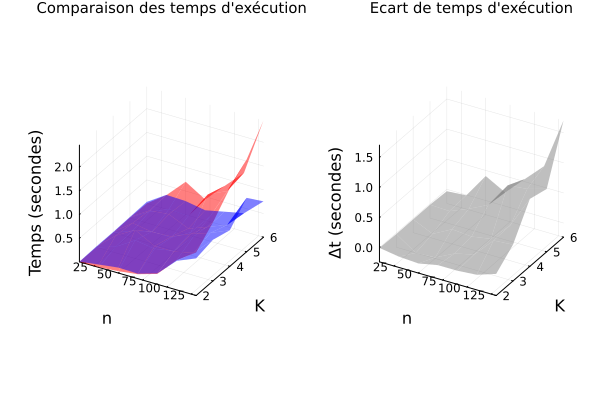

In [66]:
densite = 0.25
# Valeur de K et de n à tester
K=Array(2:6)
N=Array(10:20:130)

compare_BF_PLNE(N,K,densite)

<div style="text-align: center;">
    <img src="Images/BF_vs_PLNE.jpeg" alt="Comparaison_BF_PLNE" style="max-width: 100%; height: auto;">
</div>
$$ \text{Comparaison des méthodes de résolution du sous problème (image du 10/11/2024)} $$ 

Sur le graphique final, on observe que les temps de calcul obtenu avec **Bellman-Ford** (surface en rouge à gauche) sont étonnemment plus longs. De plus, on remarque que, pour des instances de petite taille (n<50), **Bellman-Ford** est assez proche de la version **PLNE**. Toutefois, lorsque la taille de l'instance augmente, l'écart se creuse, et la version **PLNE** semble être encore meilleure. La valeur de $K$ semble aussi influer sur cet écart : plus $K$ est grand, et plus Bellman-Ford semble s'éloigner de l'autre version.

Ce résultat n'est pas tout à fait celui auquel nous nous attendions. En effet, en théorie, la version dérivée de Bellman-Ford devrait être plus rapide, puisque construite spécifiquement pour résoudre le sous-problème. L'implémentation que nous avons faite ne doit donc pas être très optimale, et peut certainement être améliorée. Malheureusement, faute de temps, nous ne sommes pas parvenus à identifier les causes de ces faibles performances.

#### 2°/ Initialisation de l'ensemble $\widehat{C}$

Initialement, nous avons décidé d'initialiser $\widehat{C}$ avec les cycles rendus par la formulation compacte rendant les cycles de taille 2 optimaux. Cela conduit à un ensemble de départ composé de peu de cycles.
Par la suite, pour tenter d'améliorer l'initialisation, nous avons écrit une fonction renvoyant tous les cyles de taille 2 présents dans un graphe. Cela conduit à un ensemble initial $\widehat{C}$ de taille plus grande.

L'idée est donc ici de comparer ces deux méthodes d'initialisation, afin de visualiser le gain éventuellement réalisé.

[■■■■■■■■■■■■■■■■■■■■] 5/5

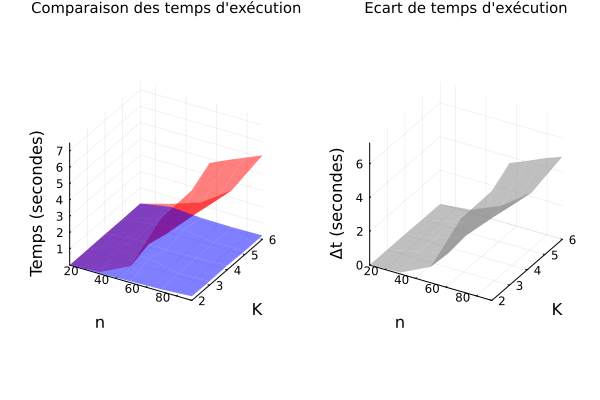

In [50]:
densite = 0.25
# Valeur de K et de n à tester
K = Array(2:6)
N = Array(10:20:90)

compare_init(N,K,densite)

<div style="text-align: center;">
    <img src="Images/compare_init.jpeg" alt="Comparaison_initialisation" style="max-width: 100%; height: auto;">
</div>
$$ \text{Comparaison des méthodes d'initialisation (image du 10/11/2024)} $$ 

La première observation est que la différence de temps d'éxecution entre l'initialisation avec les cycles optimaux de taille 2 et celle avec tous les cycles de taille 2 est toujours positive. Ainsi, initialiser $\widehat{C}$ avec tous les cycles de taille 2 est bel et bien une amélioration par rapport à l'utilisation des cycles de taille 2 optimaux.

De plus, on observe sur le graphique que cette différence semble augmenter avec la taille de l'instance (nombre de sommets du graphe). La valeur de $K$ ne semble toutefois pas impacter significativement cet écart de temps de calcul. En conclusion, ici, plus le jeu de données est grand, et plus l'amélioration semble être significative.

Ceci est certainement lié à deux choses :
- Tout d'abord, l'initialisation avec les cycles optimaux nécessite de créer un modèle JuMP, et de le résoudre, ce qui semble être une source de ralentissement.
- De plus, avec l'initialisation des cycles optimaux, $\widehat{C}$ est de taille inférieure, ce qui conduit certainement à un nombre d'itération plus grand dans l'algorithme de génération de colonnes.

### Test des limites

Dans cette 3e partie de test, nous allons essayer d'évaluer les limites de notre meilleur algorithme. Nous allons donc utiliser la méthode de génération de colonnes, avec l'initialisation "all2", et la modélisation PLNE pour la résolution de son sous-problème.

Tout d'abord, l'idée est d'évaluer l'impact de n et K sur le temps de calcul de notre fonction. Puis, dans un second temps, nous allons tenter de déterminer jusqu'à quelle taille d'instance l'algorithme fonctionne "en temps raisonnable".

[■■■■■■■■■■■■■■■■■■■■] 8/8

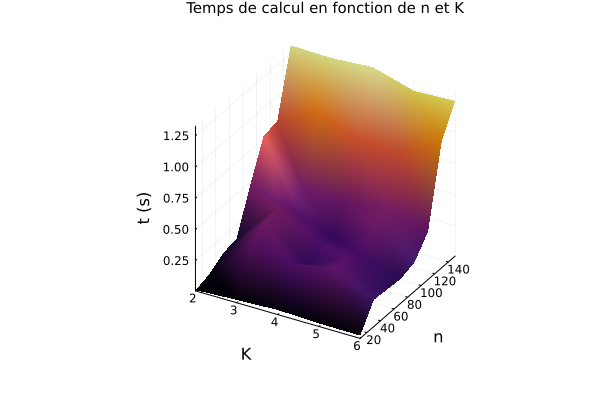

In [69]:
densite = 0.25;
# Valeurs de K et de n souhaitées
K = Array(2:6)
N = Array(10:20:150)

test_limit_N_K(N, K, densite)

<div style="text-align: center;">
    <img src="Images/limit_n_k.jpeg" alt="Temps_calcul_n_k" style="max-width: 100%; height: auto;">
</div>

$$ \text{Temps de calcul en fonction de n et K (image du 10/11/2024)} $$ 

On remarque une explosion du temps de calcul lorsque $n$ augmente. Cependant, la valeur de $K$ ne semble pas influer sur le temps de calcul. Ainsi, pour pousser les limites du code encore plus loin, nous proposons de travailler à $K$ fixé, et de faire varier $n$. Comme pour le test précédent, nous ferons encore un temps moyenné sur 3 instances pour chaque $n$.

Afin de ne pas travailler dans le cas simple $K=2$, nous proposons d'utiliser $K=3$ pour le test suivant.

[■■■■■■■■■■■■■■■■■■■■] 13/13

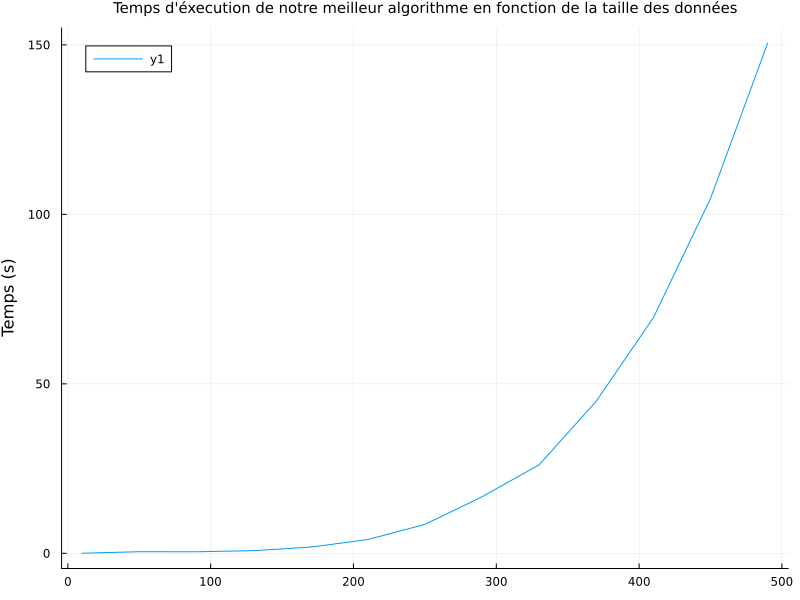

In [52]:
densite = 0.25;
# Valeurs de K et de n souhaitées
K = 3
N = Array(10:40:510)

test_limit_N(N, K, densite)

<div style="text-align: center;">
    <img src="Images/limit_n.jpeg" alt="Temps_calcul_n" style="max-width: 100%; height: auto;">
</div>

$$ \text{Temps de calcul en fonction de n (image du 10/11/2024)} $$ 

Comme prévu, on observe bel et bien que le temps de calcul explose avec le nombre de patients. Nous n'irons pas plus loin en termes de taille d'instance, l'idée étant d'avoir ici validé le fait que le temps de calcul augmente exponentiellement avec $n$. Ce test permet également de voir jusqu'à quelle taille d'instance il peut fonctionner en temps "raisonnable", bien que les tests aient été réalisés sur une machine donnée (les résultats peuvent donc différer sur une autre machine plus, ou moins puissante).

#### Utilisation du code dans un cas simple

Nous avons pu observer les performances de notre algorithme pour des instances de taille assez conséquente, que l'on peut juger comme étant ingérables à la main.

Avant de passer aux tests suivants, nous allons regarder les performances du modèle dans un cadre bien plus simple : un graphe composé d'arcs formant des couples disjoints les uns des autres. Ce cas correspond à une instance dont la résolution à la main est très facile, l'idée étant de voir si notre algorithme réagit bien face à ce genre de graphe.

Pour tester cela, nous proposons d'utiliser une première fois l'algorithme sur une instance aléatoire, et d'en extraire les cycles solutions. Nous construirons ensuite un nouveau graphe, de même taille, ayant pour arcs les cycles rendus par la première résolution.

En utilisant cette méthode, lors du second appel, nous appliquons notre algorithme sur une instance triviale (cycles déjà formés).

Pour réaliser ce test, dans le second appel de la fonction, nous ne souhaitons pas avoir uniquement des cycles de taille 2. En effet, dans ce cas, l'initialisation donne directement la solution, et l'algorithme sera donc très performant. En conséquence, nous souhaitons plutôt initialiser le nouveau graphe avec des cycles de taille supérieure, et, si possible, avec peu de cycles de taille 2. 

Pour cela, nous considèrerons, dans le graphe initial, un nombre assez limité d'arcs (10% du nombre maximum).

In [53]:
# Paramètres de la résolution
n = 100
densite = 0.1
e = 1e-6
m = round(Int,densite*n*(n-1))
K = 3
print_log = 0

# Génération d'un graphe aléatoire, et première résolution
graph = generation_graphe(n,m)
model = heuristique_gencol(graph,K,"all2",e,"BF",print_log)

# On récupère les cycles solution, et créons un nouveau graphe
cycles = model[2]
new_A = vcat(cycles...)
# Le nouveau graphe est formé des cycles solution
new_W = zeros(Float64,n,n)
new_preds = [[] for i in range(1,n)]
new_succ = [[] for i in range(1,n)]
# Mise à jour des prédécesseurs/successeurs
for arc in new_A
    push!(new_preds[arc[2]],arc[1])
    push!(new_succ[arc[1]],arc[2])
    new_W[arc[1],arc[2]] = 1.0
end
# Nouveau graphe
new_graph = [n,new_A,new_W,new_preds,new_succ]
# Résolution du modèle avec le nouveau graphe
t = @elapsed model = heuristique_gencol(new_graph,K,"all2",e,"PLNE",print_log);

# Affichages
println("Les cycles rendus correspondent-ils à la solution évidente ? "*string(Set(model[2])==Set(cycles))*".")
println("Temps de calcul : "*string(t)*"s.")
println("Nombre d'itérations : "*string(model[4])*".")

Les cycles rendus correspondent-ils à la solution évidente ? true.
Temps de calcul : 0.4180826s.
Nombre d'itérations : 11.


Comme nous pouvons le voir ici, la résolution est asssez immédiate : la solution est rendue en un temps minime, de l'ordre de la seconde. Nous pouvons d'ailleurs voir que le nombre d'itérations réalisées est très faible. La méthode réagit donc assez bien dans un cas d'instance simple, dont la solution peut être trouvée à la main, ce qui est une bonne chose.

### Questionnements de la méthode implémentée

D'après les deux articles mis à notre disposition, les programmes d'échange de reins en domino en Europe se font majoritairement à l'échelle nationale, avec quelques programmes internationaux commençant à émerger. De plus, la taille des listes de paires inscrites dans un programme d'échange est très variable, selon l'échelle du programme (régional, national ou international). 

D'autres facteurs peuvent jouer sur le nombre de paires dans un programme, comme la politique des pays sur les paires ABO-incompatibles (i.e. incompatibles au niveau du groupe sanguin) : puisqu'il existe une méthode permettant à un patient de recevoir un rein de son donneur associé pourtant ABO-incompatible, certains pays vont préférer cette option, tandis que d'autres vont préférer inscrire quand même le couple dans le programme d'échange.

Ainsi, dans la littérature et sur internet, on retrouve des instances de taille allant de 10 couples à plusieurs centaines voire milliers.

Dans ce projet, la fonction à maximiser est $\sum_{c \in \mathcal{C}_K} x_c.p(c)$ avec $p(c) = \sum_{a \in c} p_a$. Dans notre cas, $p_a=1 ~\forall ~ a \in A$, $p(c)$ correspond donc au nombre de sommets dans le cycle $c$ : on maximise le nombre de greffes réalisées.

Cependant, d'autres fonctions objectif pourraient aussi être considérées :
- $\sum_{c \in \mathcal{C}_K} x_c$ pour maximiser le nombres de cycles utilisés (conduisant à des cycles de taille plus petite)
- $\sum_{c \in \mathcal{C}_K} x_c.p(c)$ avec un poids $p_a$ différent pour chaque patient, pour maximiser le poids total des greffes effectuées

Ainsi, ce choix est à refléchir et va influencer la solution rendue par l'algorithme de génération de colonne.

**A qui cet algorithme pourrait être utile, et à quelle échelle ?**

Dans le cas de notre algorithme, nous avons établit qu'il fonctionne en "temps raisonable" pour des instances allant jusqu'à 500 paires environ. Bien entendu, ces résultats ont été réalisé sur un ordinateur donné, et l'utilisation de machines plus performantes peut étendre cette capacité de résolution.

Dans notre cas, nous résolvons le problème KEP en maximisant "l'utilité" des cycles construits (en général égal au nombre de transplantations réalisées, les poids étant fixés à 1). Il est important de noter que notre code reste d'un niveau assez bas. En effet, en comparaison avec d'autres algorithmes de la littérature, on s'aperçoit que de nombreuses autres optimisations sont possibles. La considération de donneurs altruistes, la maximisation de cycles contenant des sous-cycles admissibles, prendre en compte des paires déjà compatibles, ou encore répertorier plusieurs donneurs pour un malade donné en sont des exemples.

En se basant sur les données fournies dans les articles vus en cours, selon nous, le code construit pourrait être utilisé à l'échelle d'un (ou plusieurs) établissement(s) hospitalier(s). Compte tenu de l'approche simple et assez naïve, les résultats du code pourraient être utilisés en pratique pour valider des résultats proposés à la main par des médecins, ou fournir une première base de travail pour construire de tels cycles.

Cette approche permettrait de gagner un temps précieux pour construire une première solution, qui serait ensuite améliorée en considérant des facteurs extérieurs non présents dans notre méthode de résolution (comme ceux présentés précédemment par exemple). Un protocole de modification de la solution rendue pourrait d'ailleurs être établi, en analysant les individus isolés, la longueur de certains cycle, et les propriétés de chaque patient (possibilité d'avoir d'autres donneurs, de conduire une désensitivation,..etc.).

Jusqu'à maintenant, nous sommes restés assez loin du modèle. Nous avons implémenté une méthode, testé ses différentes variantes, et évalué ses performances. Désormais, nous souhaitons analyser les résultats rendus. Cette analyse sera une base de travail pour remettre en cause le modèle utilisé, en identifiant ses failles, et ses atouts.

#### Étude et comparaison des patients greffés ou non

**Proportion de patients greffés**

Pour commencer, nous proposons de voir quelle est la proportion de patients greffés, c'est-à-dire quelle est la proportion de sommets présents dans les cycles optimaux rendus par l'algorithme. Pour cela, nous allons utiliser les instances KEP de la Preflib.

Proportion moyenne de sommets présents dans les cycles solution : 43.58%
Proportion minimum de sommets présents dans les cycles solution : 22.22%
Proportion maximum de sommets présents dans les cycles solution : 64.84%


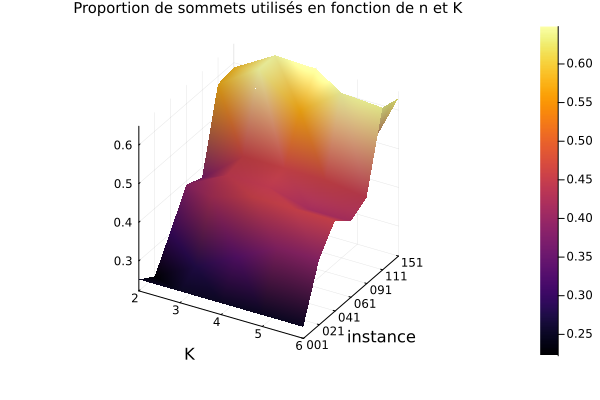

In [61]:
# Choix des instances et valeurs de K à tester
K = Array(2:6)
indexes = ["001","021","041","061","091","111","151"]

proportion_sommets_solution(K, indexes)

<div style="text-align: center;">
    <img src="Images/proportion_sommets.png" alt="prop_sommets" style="max-width: 100%; height: auto;">
</div>

$$ \text{Proportion de sommets utilisés en fonction de n et K (image du 11/11/2024)}$$ 

La première constatation est que, en moyenne, moins de 50% des patients pourront être greffés suite à une résolution du problème. Sur nos exemples, la proportion maximale de greffes atteinte est 64.8% et la proportion minimale est 22.2%. De plus, la surface nous apporte deux autres informations :
- la proportion de patients greffés semble augmenter avec le nombre de patients inscrits dans le programme. Ce résultat est cohérent avec un paragraphe de l'article *Modelling and optimisation in European Kidney Exchange Programes*, selon lequel les pays avec les programmes les plus grands permettent d'augmenter la probabilité de trouver des compatibilités (i.e. d'augmenter le nombre d'arcs par sommet), et donc la probabilité de trouver un cycle passant par ce sommet.
- la proportion de patients greffés ne semble en revanche pas augmenter ou diminuer avec K. Il semblerait cependant qu'à n fixé, c'est K = 3 qui permette la proportion la plus grande.

Ainsi, le nombre de patients dans le programme a une influence sur la proportion de patients greffés. K a, en revanche, moins d'influence mais en a tout de même : son choix a un pouvoir de décision sur les patients greffés.

**Différences entre les patients greffés et non greffés**

Maintenant que nous avons plus d'informations sur la proportion de patients présents dans les cycles optimaux, essayons d'étudier les différences entre les patients greffés et non-greffés. En particulier, nous allons comparer la proportion d'arcs (sortant et entrants) associé à chaque sommet : leur "densité de liaison". C'est le nombre d'arcs associés à un sommet divisé par le nombre maximal d'arcs associés à un sommet ($2*(nb\_sommets-1)$). Nous allons tester cela pour différentes instances et à K fixé.

In [15]:
# Choix de K et des instances de test
K = 3
indexes = ["001","021","041","061","091","111"];

difference_liaison_sommets(K, indexes)

Densité de liaison moyenne pour les sommets présents dans les cycles optimaux : 0.33
Densité de liaison moyenne pour les sommets non présents dans les cycles optimaux : 0.197


Nous observons qu'en moyenne, les sommets qui ne sont pas présents dans les cycles solution sont moins liés aux autres sommets du graphe que les sommets présents dans les cycles solutions. Ce résultat est assez intuitif, puisque les sommets avec plus de liens ont plus de chances de faire partie d'un cycle et donc d'être sélectionné dans l'algorithme.

D'un point de vue plus pratique, cela signifie qu'un individu qui a un groupe sanguin favorable à la greffe (qui peut donner à beaucoup d'autres groupes, et/ou recevoir de beaucoup de groupes), aura plus de chances d'être intégré à un cycle. Comme dit précédemment, cette propriété semble être assez réaliste.

Pour aller plus loin, nous allons regarder si certains sommets sont totalement absents de $\widehat{C}$ tout le long de l'algorithme de génération de colonne et quelles sont leurs caractéristiques. 

In [16]:
K = 3
index = "031"

sommets_absents_C_hat(K, index)

Densité du graphe : 0.328
Pourcentage de sommets absents de C_hat : 21.9 %
- Pour les sommets absents de C_hat -
Proportion d'arcs par sommet moyenne : 0.233
Proportion d'arcs entrants moyenne : 0.124
Proportion d'arcs sortants moyenne : 0.341


Ce test nous informe qu'il y a en effet des sommets qui ne sont pas présents dans l'ensemble $\widehat{C}$ à la fin de l'algorithme. Sur l'instance KEP_031, avec $K$ = 3, cela représente 20% des sommets, ce qui n'est pas négligeable. D'après les proportions affichées et comparées à la densité globale du graphe, ce sont des sommets qui sont peu liés à d'autre sommets (peu de compatibilités), et ici qui ont surtout peu de liens entrants, i.e. ce sont des paires dont le patient est rare. C'est ce qu'on observe sur la plupart des instances, même si parfois, comme avec l'instance KEP_041 ci-dessous, c'est la proportion d'arcs sortants qui est la plus faible, i.e. ce sont les donneurs qui ont peu de compatibilités avec les autres patients.

In [17]:
K = 3
index = "041"

sommets_absents_C_hat(K, index)

Densité du graphe : 0.216
Pourcentage de sommets absents de C_hat : 36.4 %
- Pour les sommets absents de C_hat -
Proportion d'arcs par sommet moyenne : 0.115
Proportion d'arcs entrants moyenne : 0.138
Proportion d'arcs sortants moyenne : 0.091


En résumé, il existe pour toutes les instances des patients (en plus ou moins grand nombre) qui ne sont jamais ajoutés à C_hat et n'ont donc aucune chance d'être dans la solution. Cela peut être des patients qui n'appartiennent à aucun cycle dans le graphe, auquel cas ils ne peuvent évidemment pas apparaître dans C_hat, ou bien des patients qui apparaissent dans très peu de cycles car ils sont très rares. Dans ce cas, une idée pour les aider à être greffés pourrait être d'augmenter leur poids. Cette idée sera développée dans un test futur.

#### Variation de la solution en fonction du choix de résolution du sous-problème

Nous avons vu précédemment que l'utilisation de la formulation PLNE ou de l'algorithme de Bellman-Ford pour résoudre le sous-problème impacte les cycles solution. Ainsi, ce choix de méthode, a priori arbitraire, éventuellement lié à la différence de temps d'exécution entre les deux n'est pas si anodin car certains patients pourraient être greffés avec l'une des 2 méthodes mais pas avec l'autre.

Dans cette partie, on se propose de comparer les solutions rendues avec les deux méthodes. L'idée est ici d'observer qualitativement les changements éventuels, qui posent bien évidemment des questionnements puisqu'un choix est réalisé.

In [ ]:
indexes = ["001","021","041","061","091","111"];
K = Array(2:6)

sommets_BF_vs_PLNE(K, indexes)

Différence moyenne du nombre de sommets dans les solutions rendues avec BF ou PLNE : 1.2
Proportion de sommets communs parmi les sommets des cycles optimaux : 0.915
Cas de K = 3
- Différence moyenne du nombre de sommets : 0.0
- Proportion moyenne de sommets communs : 0.915


Ici, en moyennant sur plusieurs instances et valeurs de K, on voit que les solutions obtenues en résolvant le sous-problème avec Bellman-Ford ou un PLNE ne contiennent pas toujours le même nombre de sommets (en moyenne un peu plus d'un sommet de différence). À noter que cette différence du nombre de sommets est dûe au fait qu'après avoir obtenu la solution optimale de la relaxation (LP), nous résolvons le PLNE sur l'ensemble $\widehat{C}$ mais rien ne nous garantit que la solution obtenue est optimale. Si nous avions réalisé un Branch&Price par exemple, le nombre de sommets devrait être le même avec Bellman-Ford ou le PLNE.

Nous observons également que la proportion de sommets communs reste en moyenne assez proche de 1, donc il n'y a pas une grande différence de patients greffés ou non en fonction du choix de la méthode. Mais bien que cette différence soit petite, elle n'est pas nulle, donc on ne peut pas dire que le choix de Bellman-Ford ou PLNE soit arbitraire et ne change pas la solution.

Ce qui est intéressant aussi, c'est qu'ici pour K = 3, toutes les instances ont le même nombre de sommets solution. En revanche, la proportion moyenne de sommets communs n'est pas égale à 1. Ainsi, même quand les deux méthodes rendent le même nombre de sommets dans les cycles solutions, ceux-ci peuvent être différents.

Ainsi, le choix de la résolution du sous-problème n'est pas si anodin et peut permettre à certains patients d'être greffés dans un cas et pas dans l'autre.

#### Parcourir les sommets dans un ordre différent 

Au même titre que le choix de la méthode, l'ordre de traitement des cycles a aussi un rôle à jouer ici. En effet, au moment de la modélisation mathématique, les couples (donneur, receveur) se voient être associé à un identifiant (allant de 1 à n). Cet identifiant est bien entendu une simple manière de représenter les noeuds dans le graphe, mais pourtant, il peut changer la solution rendue, et être source d'inégalités.

**$\to$ Cas de Bellman-Ford**

Si nous optons pour l'algorithme de Bellman-Ford pour la résolution du sous-problème, nous devons identifier des cycles de coût positif. Pour cela, on commence par chercher les cycles passant par un certain sommet "o", puis, si aucun cycle n'est trouvé, on cherche les cycles passant par un autre sommet,... 

Si dans la version par défaut de Bellman-Ford, on parcourt les noeud par identifiant croissant, pourquoi ne pas plutôt commencer par le sommet 2 plutôt que le sommet 1 ? Dans un problème où l'unicité ne semble pas être de rigueur dans la majorité des cas, il semble tout à fait possible que le choix de l'ordre de parcours des sommets ait une part à jouer dans les cycles rendus. C'est ce que nous proposons de tester dans cette partie.

Pour réaliser cela, nous allons d'abord résoudre le problème avec une numérotation, puis, de manière aléatoire, nous allons changer les numéros de chaque sommet. Ceci nous donnera un nouveau graphe, sur lequel nous testerons une seconde fois notre méthode. Nous afficherons finalement les cycles obtenus dans les deux résolutions, avec en vert, les cycles identiques, et en rouge, les sommets qui n'apparaissent pas dans l'autre solution.

In [57]:
instance = ["051"];
K = 3
densite = 0.25

test_renumerotation(instance, K, "BF")

Numérotation n°1 :
 - [(2, 17), (17, 2)]
 - [(29, 31), (31, 29)]
 - [(1, 11), (11, 13), (13, 1)]
 - [(6,14),(14,21),(21,6)]
 - [(7,28),(28,32),(32,7)]


Numérotation n°2 : 
 - Any[(2, 17), (17, 2)]
 - Any[(29, 31), (31, 29)]
 - Any[(13, 1), (1, 11), (11, 13)]
 - [(6,14),(14,16),(16,6)]
 - [(28,20),(20,7),(7,28)]


Comme nous pouvons le remarquer, même avec une instance de petite taille, le simple changement de l'ordre de traitement des noeuds dans l'identification des cycles peut créer des inégalités. Dans notre exemple, certains cycles restent communs, mais, selon l'ordre traité, un receveur peut être greffé dans un cas, et n'apparaitre dans aucun des cycles solutions dans un autre (sommets en rouge). Toutefois, la majorité des sommets solutions sont identiques. 

Ce test a été réalisé sur une instance de taille modeste, et nous pouvons tout à fait imaginer qu'en augmentant $n$ et $K$, le nombre d'inégalités augmente (puisque le nombre de cycles solutions augmente lui aussi).

**$\to$ Cas du PLNE**

Dans l'optique où nous choisissons plutôt la résolution PLNE pour le sous-problème, les indices utilisés pour représenter chaque couple peut aussi influer sur la solution obtenue. En effet, dans la résolution d'un programme linéaire, bien souvent, la méthode de résolution est basée sur un Branch & Bound. Le choix de la numérotation peut donc conduire à un traitement prioritaire de certains sommets, source évidente d'inégalités.

In [59]:
instance = ["051"];
K = 3
densite = 0.25

test_renumerotation(instance, K, "PLNE")

Numérotation n°1 :
 - [(2, 17), (17, 2)]
 - [(29, 31), (31, 29)]
 - [(1,32),(32,7),(7,1)]
 - Any[(6, 14), (14, 21), (21, 6)]
 - [(11,13),(13,16),(16,11)]


Numérotation n°2 : 
 - Any[(2, 17), (17, 2)]
 - Any[(29, 31), (31, 29)]
 - Any[(6, 14), (14, 21), (21, 6)]
 - [(1,11),(11,13),(13,1)]
 - [(7,28),(28,32),(32,7)]


Comme nous pouvons le voir, la version PLNE souffre du même problème. 

Ceci est une propriété qui peut poser problème : la solution est dépendante de la numérotation des individus. Ceci signifie que certains individus pourraient être favorisés par rapport à d'autres, simplement par l'indice qui leur a été attribué. 

On observe aussi qu'en général, les cycles différents sont très proches : ils lient des sommets identiques, et, bien souvent, un seul sommet est différent. Ceci montre que les inégalités observées ne s'appliquent qu'à certains individus, qui sont certainement très similaires pour l'algorithme (successeurs et/ou prédécesseurs similaires).

Dans un cadre opérationnel, il pourrait être intéressant d'appliquer l'algorithme pour plusieurs numérotations, et de comparer les résultats obtenus. Cette analyse qualitative permettrait de considérer les propriétés des patients, qui ne sont pas considérées dans notre algorithme, afin de privilégier certaines paires avec ce critère. Bien entendu dans ce cas, le choix du critère peut être remis en cause, et être lui aussi source d'inégalités.

Il faut ici bien garder à l'esprit que les solutions rendues sont souvent des bornes inférieures de la solution optimale. Ainsi, il peut arriver que deux résolutions avec changement de numérotation rendent des solutions réalisables de valeur optimale différente. En conséquence, il est clair que dans ce cas de figure, le nombre de sommets différents est encore supérieur.

#### Analyse éthique des résultats

Dans les parties précédentes, nous avons déjà testé les implémentations suivant plusieurs axes : qualité des solutions rendues, analyse des améliorations proposées, test des limites du code et remise en question du modèle.

Désormais, nous proposons de réaliser une dernière partie, consacrée à l'analyse "éthique" des solutions données par notre algorithme. Le but principal étant d'illustrer certains propos établis précédemment, et de se rendre compte, par la pratique, des phénomènes mis en jeu.

A cet effet, nous considèrerons des instances de taille assez petite, l'idée étant de conserver une interprétabilité et une visualisation correcte des solutions.


**1 - Un individu urgent et rare**

Dans ce premier cas, nous allons considérer un ensemble de patients dans lequel se trouve un patient très urgent et rare. Son urgence se caractérisera par un poids plus grand. Nous considèrerons que ce patient est "rare", i.e. avec une densité de liaison plus faible que les autres patients (compatibles avec peu d'autres paires).

Nous pourrons d'ailleurs voir l'impact du poids attribué à ce patient dans sa participation aux cycles solutions.

In [60]:
# Paramètres de la résolution
e = 1e-6
K = 3
print_log = 0

# Instance, individu rare et proportion d'arcs à supprimer
instance = ["031"]
individu = 1
prop = 0.8

graph = generate_ind_urgent(instance,individu,prop)

# Désormais, de manière itérative, on va incrémenter le poids des arcs liant l'individu test aux autres
## On sortira de la boucle lorsque 
test = false
poids = 1.0

liste_sommets = []

while !test
    # Mise a jour du poids du patient urgent
    for p in graph[4][individu]
        graph[3][p,individu] = poids
    end
    # Résolution avec ce graphe
    model = heuristique_gencol(graph,K,"all2",e,"PLNE",print_log);
    
    # Affichage des cycles solution, avec couleurs
    println("Avec un poids de "*string(poids)*" : ")
    test = is_in_sol(individu,model[2])
    
    show_cycle_ethic(model[2],individu)
    println("\n")
    # Incrémentation du poids du patient urgent
    poids += 1
    
    # On garde en mémoire les patients transplantés pour l'itération courante
    liste_arcs = vcat(model[2]...)
    liste = []
    for (i,j) in liste_arcs
        push!(liste,i)
    end
    # Ajout des patients transplantés à l'historique 
    push!(liste_sommets,liste)
    
    # Cas où le patient n'apparaît dans aucun cycle de taille <= K
    if poids > model[3][2]
        println("Erreur : il n'existe pas de cycle passant par l'individu test.")
        test = false
    end
end
# Affichage des patients qui ont été écartés pour transplanter l'inidividu 1
print("Patients écartés en faveur de l'individu 1 : ")
println(setdiff(liste_sommets[length(liste_sommets)-1], liste_sommets[length(liste_sommets)]))

Avec un poids de 1.0 : 
 - [(3,19),(19,3)]
 - [(4,23),(23,4)]
 - [(5,18),(18,5)]
 - [(14,15),(15,14)]
 - [(2,29),(29,17),(17,2)]
 - [(6,9),(9,16),(16,6)]
 - [(10,13),(13,27),(27,10)]
 - [(21,30),(30,22),(22,21)]


Avec un poids de 2.0 : 
 - [(3,32),(32,3)]
 - [(5,18),(18,5)]
 - [(14,15),(15,14)]
 - [(21,22),(22,21)]
 - [(2,29),(29,17),(17,2)]
 - [(6,9),(9,16),(16,6)]
 - [(4,30),(30,7),(7,4)]
 - [(10,13),(13,27),(27,10)]


Avec un poids de 3.0 : 
 - [(3,19),(19,3)]
 - [(21,22),(22,21)]
 - [(6,30),(30,7),(7,6)]
 - [(1,4),(4,17),(17,1)]
 - [(10,14),(14,27),(27,10)]
 - [(9,23),(23,15),(15,9)]
 - [(2,18),(18,5),(5,2)]


Patients écartés en faveur de l'individu 1 : Any[32, 29, 16, 13]


On remarque ici qu'un individu rare, faiblement lié aux autres individus, ne sera en général pas greffé s'il est aussi urgent que les autres. Toutefois, si le patient devient plus urgent, et qu'il existe un cycle de taille $\le K$ passant par celui-ci, alors il peut êre pris en compte dans la solution.

Dans l'exemple précédent, avec un poids de 1, et identique aux autres patients (même densité de liaison), l'individu n'est pas prioritaire. La même observation est faite lorsque son poids est multiplié par 2. Pour que ce patient puisse être pris en compte, il faut lui attribuer un poids 3x supérieur à celui des autres. Cela illustre la possibilité de compenser la rareté par l'urgence.

Ce qu'il est important de voir ici, c'est que, dans le 3e scénario, l'individu 1 va être greffé, au détriment d'au minimum 2 autres patients. Dans notre cas, sa présence substitue la présence de 4 autres patients. 

Compte tenu de cette observation, le choix des poids n'est pas à prendre à la légère. Comme nous avions pu observer lors du projet de Recherche Opérationnelle en 4e année, il est plus que difficile de résumer l'urgence d'un patient à une valeur numérique unique. L'illustration même de cette difficulté se retrouve dans ce test : le patient 1 est-il suffisamment urgent pour ne pas greffer 4 autres personnes ?  Vaut-il mieux greffer 1 patient au détriment de la survie de 4 autres personnes ?

Le raisonnement inverse peut lui aussi être fait : en supposant que les cycles rendus correspondent aux greffes qui seront faites sur 1 semaine, si l'individu d'étude est très urgent, et que les autres patients n'ont pas un risque immédiat de décès, alors transplanter ce premier avant 4 autres semble être un choix cohérent. Encore faut-il pouvoir déterminer des poids cohérents à cette vision des choses...

Ces questions n'étant pas faciles à appréhender, une attention particulière est de rigueur, pour avoir le traitement le plus juste possible. D'autant plus que, si un individu est rare, son groupe sanguin et/ou celui de son donneur est rare : il est donc certainement plus risqué de le placer dans un cycle de greffe (il sera peut-être associé à un donneur de groupe sanguin différent, ou sera soumis à une désensitivation par exemple, ce qui augmente la probabilité d'échec de greffe).


**2 - Augmenter le poids des patients les plus rares pour voir s'ils sont plus utilisés dans des cycles solutions**

Dans un test précédent, nous avons établi que certains patients ne sont jamais ajoutés à des cycles dans $\widehat{C}$ (n'ayant donc aucune chance d'apparaître dans un cycle solution), et que ce sont des patients très peu liés, avec surtout peu d'arcs entrants (i.e. des patients avec un groupe sanguin offrant peu de compatibilités avec les donneurs). 

Nous nous proposons donc, sur l'instance KEP_071, d'augmenter le poids des 10% des patients ayant le moins d'arcs entrants (i.e. le moins de prédécesseurs), pour voir si cela les aide à apparaître dans un cycle solution.

In [ ]:
instance = "071"
K = 3

augmentation_patients_rares(K, instance)

Nombre de patients à qui augmenter le poids (les 10% ayant le moins de prédecesseurs) : 7
- Avant augmentation (poids de 1) -
Nombres de sommets parmi les 10% avec le moins de prédécesseurs dans la solution : 2
- Après augmentation (poids de 2) -
Nombres de sommets parmi les 10% avec le moins de prédécesseurs dans la solution : 5


On observe bien dans ce cas qu'après augmentation de 1 du poids des 10% de patients ayant le moins de prédecesseurs, on en retrouve 5 sur 7 dans les cycles solutions, soit 3 de plus qu'avant l'augmentation des poids. Comme vu précédemment, on peut se douter que l'apparition de ces 3 patients dans la solution optimale se fait au détriment d'autres patients qui ne sont plus greffés.

Il faut également noter qu'en augmentant le poids des 10% de patients ayant le moins de prédecesseurs, on peut se retrouver à augmenter le poids de patients que ne font partie d'aucun cycle de taille $\le K$ dans le graphe, ce qui n'aura donc aucun impact. Il n'est donc pas forcément possible de trouver un poids tel que les 7 patients (dans notre ces) se retrouvent dans la solution.

De plus, on ne s'est ici intéressés qu'aux prédecesseurs des patients, mais on pourrait tout aussi bien pu s'intéresser aux successeurs ou bien aux deux, ce qui reviendrait à augmenter le poids des paires dont le donneur a peu de compatibilités, ou bien de celles dont à la fois le patient et le donneur ont peu de compatibilités. 

Si l'on voulait implémenter ceci dans une réel échange d'organes, des choix seraient à faire et ceux-ci impacteraient le résultat final.

## Conclusion

Pour conclure cette première partie déterministe, nous pouvons résumer ce qui a été fait et ce que nous en avons tiré.

Premièrement, notre algorithme de génération de colonne semble fonctionner et rendre les bonnes solutions, d'après les tests que nous avons fait et la comparaison avec les formulations compactes. De plus, ses performances dépendent de plusieurs paramètres. La configuration qui lui permet d'être le plus rapide est d'initialiser l'ensemble $\widehat{C}$ avec tous les cycles de taille 2 du graphe, et de résoudre le sous-problème avec une formulation PLNE. Notre algorithme de Bellman-Ford pourrait être amélioré pour être plus rapide mais ce n'est pas le cas dans la version actuelle. Avec les paramètres optimaux, le temps de résolution augmente exponentiellement, et un graphe aléatoire de taille 500 conduit à un temps d'éxecution d'un peu moins de 3 minutes. Ce temps nous semble rester raisonnable.

L'écriture de cet algorithme nous a poussé à nous questionner sur les paramètres qui peuvent jouer sur la solution finale, les précautions à prendre lors de son utilisation et les éventuels changements possibles. Nous avons par exemple déterminé que dans la résolution du sous-problème, le choix de la méthode ou même la numérotation des sommets du graphe impacte les cycles et les sommets présents dans la solution. Ainsi, la solution de l'algrithme est sensible à des choix a priori arbitraire ou liés à sa performance.

Nous avons également constaté que les paires qui sont peu liées aux autres paires sont désavantagées et apparaissent moins dans la solution que les autres. C'est une observation assez intuitive mais qui pousse à refléchir. Devons-nous mettre tous les patients au même niveau ou bien augmenter le poids des patients ayant le moins de compatibilités pour les aider à être greffés ? Nous avons testé cette idée en créant d'une part, un individu rare à qui nous avons augmenté le poids (le rendant "urgent"), et d'autre part, en augmentant le poids des 10% de receveurs ayant le moins de compatibilités dans un graphe donné. Dans les deux cas, nous avons observé que l'augmentation de leur poids leur permet d'être plus facilement sélectionné dans un cycle solution. Il y a donc, encore une fois, une décision à ne pas prendre à la légère dans le choix des poids des patients.

Pour finir sur un aspect pédagogique, cette première partie du projet nous a permis de découvir et mettre en application la génération de colonne sur un problème réel, et d'approfondir notre capacité de questionnement éthique face aux outils que nous développons. 

Notons cependant que nous n'avons pas codé le processus de génération de colonne jusqu'au bout pour notre problème puisqu'après avoir trouvé la solution optimale de la relaxation du problème, nous n'avons pas implémenté de méthodes type Branch & Price mais avons seulement résolu le PLNE sur l'ensemble des cycles associé à la solution optimale de la relaxation. 

Sur tous les points cités précédemment, cette première partie du projet a été une grande source d'apprentissage, tant sur le plan technique que sur le plan humain.

# Approches avec incertitudes

Dans la pratique, il est important de savoir que les tests croisés permettant de confirmer la compatibilité entre donneurs et malades peuvent être lourds à réaliser pour les malades et qu'ils demandent des ressources importantes auprès des services hospitaliers. Chaque test est précédé de consultations médicales pour le patient et le donneur au cours desquels des tissus sont prélevés, puis des manipulations biologiques doivent être réalisées pour étudier la compatibilité des tissus. En outre, le nombre de tests croisés à réaliser est d'ordre quadratique en fonction du nombre de sommets du graphe de compatibilité. 

En pratique, le programme d'échange est donc organisé en deux phases. Lors d'une première phase de planification, l'organisme ne dispose que de données individuelles sur chaque donneur et chaque receveur pour déduire la compatibilité _a priori_ entre donneurs et patients. 
Ces données sont principalement le groupe sanguin et le complexe majeur d’histocompatibilité, aussi appelé système HLA. 
Pour ce projet, nous nous contenterons toutefois de prendre en compte le groupe sanguin. 
Il est par ailleurs possible de prendre en compte une probabilité d'échec du test croisé à partir d'autres données individuelles agrégées sous l'indicateur du pourcentage d'anti-corps réactifs (PRA) du malade de chaque paire. 

Mais, les opérations de transfert d'organe ne sont jamais planifiées avant d'avoir confirmé la compatibilité entre le donneur et le malade par un test croisé. 
Suite à la première phase, l'organisme responsable du programme d'échange planifie donc un ensemble de tests croisés pour vérifier la compatibilité entre certains malades et donneurs. 
Sachant la lourdeur des tests croisés, leur nombre est limité en pratique. 
On pourra pour cela considérer une limite fixe dépendant du nombre de paires patient-donneur ou bien supposer que les tests ne servent qu'à confirmer la compatibilité après avoir décidé les cycles d'échange entre patients a priori compatibles. 
La seconde phase du programme d'échange consiste à planifier les cycles de transferts d'organes une fois les résultats des tests croisés connus. 

Du point de vue de l'aide à la décision, la première phase de l'organisation des transferts est un problème d'optimisation sous incertitudes. On souhaite décider l'ensemble des tests croisés à effectuer pour maximiser le nombres de dons d'organe alors qu'une partie des données est incertaine. Les données individuelles de groupes sanguins et de PRA sont bien connues (on dit aussi qu'elles sont déterministes), mais la compatibilité entre donneurs et malades est incertaine (elle dépend du résultat d'un test croisé). Ici, nous sommes toutefois dans le cas où les données incertaines sont _stochastiques_ puisque nous supposerons que l'on connaît leur distribution de probabilité.

La suite du projet consistera à coder plusieurs approches d'optimisation sous incertitudes pour résoudre ce nouveau problème, plus proche des conditions réelles d'organisation des programmes d'échange d'organes. Les méthodes considérées seront introduites par des séances de cours permettant de poser leur cadre formel et d'énoncer certaines propriétés théoriques qu'elles satisfont. Ainsi, l'énoncé du travail à réaliser donné ci-dessous est synthétique, mais il sera précisé lors de séances de TD durant lesquelles nous étudierons l'application des méthodes générales au problème qui nous intéresse dans ce projet. Pour autant, les mêmes données seront exploitées dans toutes les méthodes. 

## Descriptions des données incertaines

Comme déjà vu dans le projet de l'année dernière, la compatibilité entre un malade et un donneur dépend de deux types d'information. Une partie des informations biologiques individuelles permet d'affirmer sans autre manipulation que certains donneurs sont incompatibles avec certains malades. Ici, il s'agit du groupe sanguin de chaque donneur et de chaque patient. Nous savons par exemple qu'un donneur du groupe A n'est pas compatible avec un patient du groupe B. S'il y a incompatibilité entre les groupes sanguins d'un donneur et d'un malade, on sait donc qu'il ne sera pas nécessaire de réaliser un test croisé entre ces deux personnes. 

Les groupes sanguins nous permettent donc de construire un premier graphe de compatibilité _a priori_, $\tilde G=(V,\tilde A)$ où $V$ correspond à l'ensemble des paires du programme d'échange et où un arc $a\in \tilde A$ entre deux paires $(D_k,M_k)$ et $(D_l,M_l)$ signifie que le groupe sanguin de $D_k$ n'est pas incompatible avec celui de $M_l$. 

Des tests croisés pourront ensuite être réalisés sur des arcs de $\tilde G$ si l'on pense que ces arcs pourraient être impliqués dans un cycle de transferts d'organes. Les données incertaines qui nous intéressent pour la suite correspondent donc au résultat de ces tests croisés dont nous supposons connaître la distribution de probabilité.
Plusieurs modèles d'incertitudes sont classiquement regardés dans la littérature pour modéliser la distribution de probabilité de la réussite des tests croisés. Tous considèrent cependant que la réussite d'un test réalisé sur un arc $a$ suit une loi de Bernouilli de probabilité $1-f_a$ où $f_a$ est une probabilité d'échec donnée. Les différents modèles étudiés dans la littérature peuvent considérer des probabilités d'échec constantes, mais les plus réalistes indiquent une dépendance au PRA des malades.

Dans la suite, une fonction permettant de lire les données individuelles de chaque paire patient/donneur dans les fichiers .dat de la PrefLib nous sera donnée. Sachant que l'on ne peut plus supposer connaître la compatibilité réelle (donc après test croisé) entre donneurs et malades, les informations contenues dans les fichiers .wmd ne sont plus pertinentes dans cette partie. À la place, nous construirons un graphe de compatibilité _a priori_ en nous basant sur les groupes sanguins et nous retiendrons les PRA de chaque malade dans un attribut du sommet correspondant. Vous pourrez adapter cette fonction pour les données générées selon la méthode décrite pour le projet de RO.

Je donne ensuite la fonction permettant de calculer des probabilités d'échec pour tous les arcs de $\tilde G$ en fonction d'un paramètre à choisir dans le tableau DISTRIBUTIONS et du PRA des malades.

In [15]:
DISTRIBUTIONS = ["Constant","Binomial","BinomialUNOS","BinomialAPD","NoFailure"]

@nbinclude("Formulations_avec_incertitudes/Donnees.ipynb")

Fonctions créant les graphes importées avec succès.


In [16]:
row = ["A", "B", "AB", "O"]

mat = zeros(4,4)
for i in Array(1:4)
    for j in Array(1:4)
        mat[i,j] = 1*gs_compatible(row[j],row[i])
    end
end

df = DataFrame(mat, :auto)
rename!(df, [:A, :B, :AB, :O])
df.RowName = row
println(select!(df, :RowName, :A, :B, :AB, :O))

4×5 DataFrame
 Row │ RowName  A        B        AB       O       
     │ String   Float64  Float64  Float64  Float64 
─────┼─────────────────────────────────────────────
   1 │ A            1.0      0.0      0.0      1.0
   2 │ B            0.0      1.0      0.0      1.0
   3 │ AB           1.0      1.0      1.0      1.0
   4 │ O            0.0      0.0      0.0      1.0


Comme nous pouvons le voir, avec les fonctions implémentées dans le notebook ```Donnees.ipynb```, nous retrouvons les compatibilités "a priori" des différentes groupes sanguins entre eux. Il est important de noter ici que le choix de la distribution est central dans l'attribution des probabilités d'échec. Ce choix préalable pourrait complètement changer le résultat et la conclusion a posteriori. Nous nous pencherons sur ce point dans une partie ultérieure.

### Méthode de résolution

Comme évoqué précédemment, notre nouvel objectif est de déterminer quels sont les tests croisés à réaliser. Ces tests préalables sont nécessaires et obligatoires pour réaliser une greffe entre un donneur et un malade. Les données disponibles sont les groupes sanguins de chaque malade et chaque donneur de notre problème. Ces groupes sanguins permettent, selon certaines considérations (choix de la distribution de probabilité), d'établir une probabilité d'échec du test croisé.

Ainsi, entre 2 couples (donneur/malade) $(D_i,M_i)$, $(D_k,M_k)$, nous connaissons la probabilité que le test croisé entre le donneur $D_i$ et le malade $M_k$ échoue. Ces probabilités nous donnent donc accès au graphe $\tilde{G} = (V,\tilde A)$ présenté précédemment.

En supposant que nous ayons un certain budget (nombre maximum de tests croisés que nous pouvons réaliser), notre objectif est de déterminer quels tests croisés réaliser pour maximiser le nombre potentiel de tests réussis, et donc de transplantations.

Si nous supposons connaître tous les scénarios possibles (toutes les combinaisons de compatibilité entre tous les couples qui ne sont pas incompatibles), et la probabilité de ceux-ci, nous pouvons proposer une modélisation en programmation linéaire.

A cet effet, nous noterons $\mathcal{C}_K$ l'ensemble des cycles de dons possibles, de taille $\le K$, et $\mathcal S$ l'ensemble des scénarios possibles. 

Détails de la formulation : 

- Paramètres :

    -  $ \forall (i,j) \in \tilde A, \forall s \in \mathcal S, \xi_{(i,j)}(s) = \begin{cases} 1 & \text{ si le test croisé entre $D_i$ et $M_j$ est réussi dans le scénario s} \\ 0 & \text{sinon} \end{cases}
$
    - $B$ : nombre maximum de tests croisés que nous pouvons réaliser (budget)
    - $\forall c \in \mathcal{C}_K$, $u_c$ : coût du cycle $c$ 
    - $\forall s \in \mathcal S$, $q_s$ : probabilité du scénario $s$
    - $\forall a \in \tilde A$, $\mathcal{C}_K(a)$ : Cycles de $\mathcal{C}_K$ contenant l'arc $a$
    - $\forall v \in V$, $\mathcal{C}_K(v)$ : Cycles de $\mathcal{C}_K$ passant par $v$

<br>

- Variables : 

    - $ \forall (i,j) \in \tilde A,  x_{(i,j)} = \begin{cases} 1 & \text{ si on réalise le test croisé entre le donneur $D_i$ et le malade $M_j$} \\ 0 & \text{sinon} \end{cases}
$
    - $ \forall c \in \mathcal{C}_K, \forall s \in \mathcal S,  z_{c}(s) = \begin{cases} 1 & \text{ si on réalise le cycle de dons "c" dans le scénario s} \\ 0 & \text{sinon} \end{cases}
$

<br>

- Contraintes : 
    - On réalise, au plus, $B$ tests croisés ($C_1$)
    - On ne peut réaliser un cycle de dons $c$ seulement si tous les tests croisés des arcs de ce cycle ont été faits, et réussis ($C_2$)
    - On construit, au plus, 1 cycle passant par chaque sommet ($C_3$)
    
<br>

- Modèle : 
$$
\begin{aligned}
\max & \quad \mathbb{E}_{\omega} \left[ \sum_{c \in \mathcal{C}_K} u_c \cdot z_c(\omega) \right] 
= \max \sum_{s \in \mathcal{S}} q_s \left[ \sum_{c \in \mathcal{C}_K} u_c \cdot z_c(s) \right] \\
 & \quad \sum_{(i,j) \in \tilde{A}} x_{(i,j)} \leq B \quad & (C_1) \\
& \quad \forall a \in \tilde{A}, \forall s \in \mathcal{S}, 
\sum_{c \in \mathcal{C}_K(a)} z_c(s) \le x_a \cdot \xi_a(s) \quad & (C_2) \\
& \quad \forall s \in \mathcal{S}, \forall v \in V, 
\sum_{c \in \mathcal{C}_K(v)} z_c(s) \leq 1 \quad & (C_3) \\
& \quad x_{(i,j)} \in \{0,1\}, \forall (i,j) \in \tilde A; \\
& \quad z_c(s) \in \{0,1\}, \forall s \in \mathcal{S}, \forall c \in \mathcal{C}_K.
\end{aligned}
$$

## Simulation de scénarios

Le modèle ci-dessus s'appuie sur tous les scénarios possibles $s \in \mathcal S$. Toutefois, nous ne pouvons pas tous les énumérer. A cet effet, pour estimer l'espérance ci-dessus, nous allons utiliser la loi forte des grands nombres, i.e., travailer sur un ensemble de scénarios $\mathcal {S}_N$, de taille $N$ donnée. Ceux-ci seront le résultat de $N$ simulations au sein du graphe $\tilde G$. Si $N$ est "assez grand", la LFGN assure une certaine proximité entre la moyenne empirique réalisée sur ces $N$ scénarios, et l'espérance exacte.

En considérant ce changement, nous allons d'abord simuler $N$ scénarios, puis résoudre : 

$$
\begin{aligned}
\max & \sum_{s \in \mathcal{S}_N} \frac{1}{N} \left[ \sum_{c \in \mathcal{C}_K} u_c \cdot z_c(s) \right] \\
 & \quad \sum_{(i,j) \in \tilde{A}} x_{(i,j)} \leq B \quad & (C_1) \\
& \quad \forall a \in \tilde{A}, \forall s \in \mathcal{S}_N, 
\sum_{c \in \mathcal{C}_K(a)} z_c(s) \le x_a \cdot \xi_a(s) \quad & (C_2) \\
& \quad \forall s \in \mathcal{S}_N, \forall v \in V, 
\sum_{c \in \mathcal{C}_K(v)} z_c(s) \leq 1 \quad & (C_3) \\
& \quad x_{(i,j)} \in \{0,1\}, \forall (i,j) \in \tilde A; \\
& \quad z_c(s) \in \{0,1\}, \forall s \in \mathcal{S}_N, \forall c \in \mathcal{C}_K.
\end{aligned}
$$

La fonction permettant de réaliser ces simulations se trouve dans le notebook ```Simulations.ipynb```.

In [18]:
@nbinclude("Formulations_avec_incertitudes/Simulations.ipynb")

Fonctions de simulation importées avec succès.


In [19]:
# Vérification du fonctionnement de la fonction de simulation
## Choix du graphe
Gtilde = read_dat_file("Data_KEP/KEP_071.dat");
get_failure_rates(Gtilde, "Binomial")

# Récupération des propriétés du graphe
n, A, preds, succ = compute_A(Gtilde)
W = zeros(n,n)
for e in edges(Gtilde)
    W[e.src,e.dst] = get_prop(Gtilde,e,:failure)
end
graph = [n,A,W,preds,succ] 
    
# Simulation de 100 scénarios dans le graphe choisi
N = 100
    
t = @elapsed S = simulate_scenarios(graph,N);
println("Temps pour réaliser "*string(N)*" scénarios : "*string(t)*"s.")

Temps pour réaliser 100 scénarios : 0.3109365s.


En pratique, nous savons que la taille des cycles de transplantations est rarement supérieure à 3. Dans les deux parties qui suivent, nous allons écrire 2 modèles linéaires, permettant de résoudre le problème dans les cas simplifiés $K=2$ et $K=3$.

Pour $K=2$, nous allons construire un modèle spécifique à ce cas, et pour $K=3$, nous écrirons la formulation par cycle définie précédemment, mais nous ne l'appliquerons qu'aux cycles de taille 3.

## Création des modèles de résolution

Avant toute chose, comme pour le cas déterministe, nous pouvons construire une fonction récupérant une liste de graphes, via leur nom, en utilisant la fonction ```read_dat_file```. Chaque graphe sera codé de la même manière que dans la partie précédente : une liste de taille 5, contenant la taille du graphe concerné, ses arcs, la matrice de ses poids (ici la matrice contenant les probabilités d'échec), et les listes des prédécesseurs et successeurs de chaque sommet.

In [20]:
function load_graphs_from_dat(graph_names,distribution="Binomial")
    """
    Fonction permettant d'extraire les propriétés d'une liste de graphe, donnés par leur indice.
    
    Entrée : 
        - graph_names  : Array  - Liste des indices des graphes à importer
        - distribution : String - Distribution de probabilité considérée
    
    Sortie :
        - graphs : Array - Liste des graphes souhaités
    
    """
    # Initialisation du vecteur des graphes
    graphs = []
    
    # Pour chaque indice souhaité
    for index in graph_names
        # On importe le graphe
        Gtilde = read_dat_file("Data_KEP/"*index*".dat");
        get_failure_rates(Gtilde, distribution)
        
        # On calcule n, A, preds et succ
        n, A, preds, succ = compute_A(Gtilde)
        W = zeros(n,n)
        for e in edges(Gtilde)
            W[e.src,e.dst] = get_prop(Gtilde,e,:failure)
        end
        
        # Création du graphe
        graph = [n,A,W,preds,succ]
        
        # Ajout du graphe dans la liste
        push!(graphs,graph)
    end
    
    return graphs
end

load_graphs_from_dat (generic function with 2 methods)

### Modèle pour les cycles de taille 2 uniquement

#### Construction du modèle

Pour ce premier modèle, nous allons construire 2 fonctions, l'une permettant de déterminer tous les cycles de taille 2 du graphe $\tilde G$, et une seconde permettant de construire et résoudre la formulation en programme linéaire détaillée ci-après.

Pour simplifier, nous supposons que les poids de tous les arcs sont fixés à 1.

Chaque cycle de taille 2 $((i,j),(j,i))$ est identifié par un des deux arcs (l'arc $(i,j)$ où $i < j$). Afin de diminuer le nombre de variables, la variable $x_{(i,j)}$ vaudra $1$ si, et seulement si, on réalise le test croisé entre $D_i$ et $M_j$, ainsi que celui entre $D_j$ et $M_i$. 


Détails de la formulation : 

- Paramètres :
       
    - $\mathcal{C}_K^2$ : liste des identifiants des cycles de taille 2 de $\tilde G$
    - $V_2$ : liste des sommets concernés par les cycles de $\mathcal{C}_K^2$
    - $\tilde A_2$ : liste des arcs concernés par les cycles de taille 2
    - $\forall v \in V_2$, $C_2(v)$ : indices des cycles de taille 2 passant par le sommet $v$
    
    -  $ \forall (i,j) \in \tilde A_2, \forall s \in \mathcal S_N, \xi_{(i,j)}(s) = \begin{cases} 1 & \text{ si le test croisé entre $D_i$ et $M_j$ est réussi dans le scénario s} \\ 0 & \text{sinon} \end{cases} $
    - $B$ : nombre maximum de tests croisés que nous pouvons réaliser (budget)

<br>

- Variables : 

    - $ \forall (i,j) \in \mathcal{C}_K^2,  x_{(i,j)} = \begin{cases} 1 & \text{ si on réalise le test croisé entre $D_i$, $M_j$ et entre $D_j$, $M_i$ } \\ 0 & \text{sinon} \end{cases}
$
    - $ \forall c \in \mathcal{C}_K^2, \forall s \in \mathcal S_N,  z_{c}(s) = \begin{cases} 1 & \text{ si on réalise le cycle de dons dans le scénario s} \\ 0 & \text{sinon} \end{cases}
$

<br>

- Contraintes : 
    - On réalise, au plus, $B$ tests croisés ($C_1$)
    - On ne peut réaliser un cycle de dons $c$ uniquement si tous les test croisés des arcs de ce cycle ont été faits, et réussis ($C_2$)
    - On construit, au plus, 1 cycle passant par chaque sommet ($C_3$)
    
<br>

- Modèle : 
$$
\begin{aligned}
\max & \quad \sum_{s \in \mathcal{S}_N} \frac{1}{N} \left[ \sum_{c \in \mathcal{C}_K^2} 2.z_c(s) \right] \\
& \quad \sum_{(i,j) \in \mathcal{C}_K^2} 2.x_{(i,j)} \leq B \quad & (C_1) \\
& \quad \forall (i,j) \in \mathcal{C}_K^2, \forall s \in \mathcal{S}_N, \quad 
2 \cdot z_{(i,j)}(s) \le x_{(i,j)} \cdot (\xi_{(i,j)}(s) + \xi_{(j,i)}(s)) \quad & (C_2) \\
& \quad \forall s \in \mathcal{S}_N, \forall v \in V_2, \quad 
\sum_{c \in \mathcal{C}_2(v)} z_c(s) \leq 1 \quad & (C_3) \\
& \quad x_{(i,j)} \in \{0,1\}, \forall (i,j) \in \mathcal{C}_K^2; \\
& \quad z_c(s) \in \{0,1\}, \forall s \in \mathcal{S}_N, \forall c \in \mathcal{C}_K^2.
\end{aligned}
$$


Les deux fonctions concernées sont écrites dans le notebook ```Uncertain_Model_2.ipynb```. Dans ce notebook, une troisième fonction est aussi construite : ``pb_recours_2``.  L'intérêt de cette fonction est discuté ci-après.

In [22]:
@nbinclude("Formulations_avec_incertitudes/Uncertain_Model_2.ipynb")

Fonctions de résolution du problème de taille 2 importées avec succès.


Nous pouvons désormais lancer la résolution de cette formulation sur l'instance "KEP_031", avec 100 simulations et un nombre maximal de tests croisé égal à 32. $B$ est donc ici choisi de manière assez arbitraire, mais ce choix sera remis en cause dans des tests ultérieurs. Ce lancement permettra de nous assurer qu'aucune anomalie n'est présente dans notre formulation. Nous testerons plus en profondeur cette méthode de résolution par la suite.

Il est important de noter ici que la valeur optimale $\hat z$ rendue par l'algorithme ne constitue pas une estimation du nombre de transplantations. En effet, cette valeur est issue d'un nombre de simulations assez petit, puisqu'elle sert de base à notre calcul d'optimisation. L'approximation de l'espérance par la moyenne empirique ne fonctionnant que pour un nombre de simulations assez grand, nous calculerons le nombre espéré de transplantations "exact" en considérant un nombre de simulations plus grand, et en utilisant la valeur optimale de la variable $x$ rendue par la première résolution. Nous noterons $\overline z$ la valeur optimale obtenue.

Ce second calcul réutilisera donc la formulation pour les cycles de taille 2, mais en fixant la variable $x$ aux tests croisés que nous aurons décidé de réaliser. Pour simplifier, cette opération sera réalisée dans la fonction ```pb_recours_2```, semblable en tout point à la formulation ```uncertain_model_2```, mais sans la variable $x$.

In [26]:
# Test réalisé sur l'instance KEP_031
graph = load_graphs_from_dat(["KEP_031"])[1]

# Récupération des arcs et sommets du graphe restreint aux cycles de taille 2
C_2,V_2,C_v,A_2 = get_cycles_2(graph)
graph[2] = A_2
  
# Paramètres de la résolution
N = 100
B = 32

# Simulation des scénarios
S = simulate_scenarios(graph,N);

# Résolution de la formulation
obj,model,timer = uncertain_model_2(C_2,V_2,C_v, S, B,true)
# Affichage de la solution rendue
arcs = compute_solution_uncertain_2(model);

# Approximation du nombre moyen de transplantations
S_prime = simulate_scenarios(graph,10*N);
Obj, model, timer = pb_recours_2(C_2,V_2,C_v, S_prime, false, value.(model[:x]))
println("\nEstimation du nombre espéré de transplantations : ", Obj)

***** Uncertain *****
Statut de la solution = OPTIMAL
Valeur optimale = 12.66
Temps = 0.1069493
Tests croisés à réaliser : 
  - (1, 11) & (11, 1)
  - (2, 32) & (32, 2)
  - (3, 17) & (17, 3)
  - (4, 5) & (5, 4)
  - (4, 7) & (7, 4)
  - (5, 18) & (18, 5)
  - (5, 20) & (20, 5)
  - (5, 30) & (30, 5)
  - (6, 14) & (14, 6)
  - (9, 30) & (30, 9)
  - (13, 21) & (21, 13)
  - (15, 22) & (22, 15)
  - (16, 27) & (27, 16)
  - (19, 32) & (32, 19)
  - (21, 23) & (23, 21)
  - (21, 30) & (30, 21)

Estimation du nombre espéré de transplantations : 12.82


Cette première résolution ne semble pas présenter d'anomalie particulière, ce qui est rassurant. Nous étudierons plus en profondeur la validité de cette résolution dans le cadre de tests ultérieurs.

### Formulation pour les cycles de taille 3

Dans le cas des cycles de taille 3, nous allons écrire la formulation par cycle présentée précédemment. Nous écrirons également une fonction permettant de déterminer tous les cycles de taille 3 du graphe $\tilde G$.

Pour déterminer ceux-ci, nous allons itérer sur les arcs de $(i,j) \in \tilde A$, avec $i < j$. Nous établirons ensuite l'intersection entre les successeurs de $j$, et des prédécesseurs de $i$. En identifiant les sommets "$k$" de cette intersection, nous obtenons les cycles de taille 3 de la forme ($(i,j),(j,k),(k,i)$). 

Comme pour le cas $K=2$, une fonction ``pb_recours_3`` sera aussi  construite, afin de résoudre le problème de recours à $x$ fixé.

*Voir ```Uncertain_Model_3.ipynb```*.

In [24]:
@nbinclude("Formulations_avec_incertitudes/Uncertain_Model_3.ipynb")

Fonctions de résolution du problème de taille 3 importées avec succès.


Comme pour le cas $K=3$, nous proposons de vérifier le fonctionnement de cette formulation, sur le même exemple. Nous considérons donc de nouveau l'instance "KEP_031", avec 100 simulations et 32 tests au maximum.

Nous calculerons également l'estimation du nombre espéré de transplantations $\overline z$ en résolvant le recours avec les tests croisés optimaux.

In [27]:
# Récupération des cycles,...
C, C_a, C_v, U, A_3, V_3 = get_cycles_3(graph)
graph[2] = A_3
  
# Paramètres de la résolution
N = 100
B = 32

# Simulation des scénarios
S = simulate_scenarios(graph, N);
# Résolution de la formulation
obj,model,timer = uncertain_model_3(A_3,V_3,C, C_a, C_v, U, S, B,true)
# Affichage de la solution
arcs = compute_solution_uncertain(model);

# Approximation du nombre moyen de transplantations
S_prime = simulate_scenarios(graph,10*N);
Obj, model, timer = pb_recours_3(A_3,V_3,C, C_a, C_v, U, S_prime, false, value.(model[:x]))
println("\nEstimation du nombre espéré de transplantations : ", Obj)

***** Uncertain *****
Statut de la solution = OPTIMAL
Valeur optimale = 13.839999999999982
Temps = 0.8786169
Tests croisés à réaliser : 
  - (21, 13)
  - (2, 32)
  - (5, 20)
  - (21, 30)
  - (17, 7)
  - (4, 16)
  - (1, 11)
  - (27, 16)
  - (5, 11)
  - (16, 27)
  - (17, 3)
  - (30, 9)
  - (3, 17)
  - (11, 20)
  - (30, 21)
  - (22, 15)
  - (30, 5)
  - (13, 21)
  - (19, 1)
  - (7, 6)
  - (3, 19)
  - (32, 3)
  - (15, 22)
  - (20, 5)
  - (32, 2)
  - (27, 4)
  - (11, 1)
  - (1, 19)
  - (19, 32)
  - (20, 30)
  - (9, 30)
  - (6, 17)

Estimation du nombre espéré de transplantations : 13.985


La résolution ne présente pas non plus d'anomalie partciulière, ce qui est encore une fois rassurant. Nous observons d'ailleurs que le nombre espéré de transplantation est supérieur au cas $K=2$. Toutefois, ce résultat est obtenu avec des simulations différentes, et cette observation mériterait des test ultérieurs.

### Tests des méthodes

Dans cette partie, on se propose de tester les 2 formulations décrites ci-dessus. Nous considèrerons dans un premier temps des tests vérifiant des propriétés théoriques vues en cours afin de nous assurer du bon fonctionnement de notre formulation. Nous tenterons ensuite de montrer que l'approche avec recours se révèle être plus intéressante que d'autres approches plus simples. Enfin, nous discuterons des différents choix de modélisation faits et de leurs impacts.

In [52]:
@nbinclude("Formulations_avec_incertitudes/Tests.ipynb")

Fonctions de test importées avec succès.


Au cours des différents tests qui suivent, nous ferons le choix de ne pas utiliser l'instance "KEP_001". En effet, cette instance est de dimension très petite, et avec peu de lien entre les individus.

#### 1 - Vérification du fonctionnement du code

**$\to$ Visualisation de la convergence**

Une première propriété du cours est la suivante : l'estimateur du nombre espéré de transplantations converge vers la valeur optimale du problème exact lorsque le nombre de simulations augmente. On a donc :
$$
\underset{\underset{N \to +\infty}{p.s.}}{\lim} \hat{Z_N} = z^*
$$

Nous proposons de vérifier cette première assertion. Pour cela, pour des valeurs de $N$ croissantes, nous allons résoudre le problème incertain, puis afficher l'évolution de la valeur optimale rendue en fonction du nombre de simulations. Nous ferons ce test pour la résolution avec cycles de taille $\le 2$ et de taille $\le 3$.

Nous proposons de réaliser ce test sur l'instance "KEP_031", avec $B=200$ et $N$ variant entre 10 et 1000.

Ici, nous visualiserons uniquement la convergence d'une réalisation $\hat z_N$ de la variable aléatoire $\hat Z_N$, et non la convergence de la variable aléatoire elle-même. Ce test a donc une vocation purement illustrative, afin de nous conforter à l'idée que $\hat Z_N$ converge vers une valeur à mesure que $N$ augmente.

Dans un prochain test, nous effectuerons un test sur la décroissance de $\mathbb{E}[\hat z_N]$ permettant de considérer plusieurs réalisations de $\hat Z_N$ et de mieux étudier la convergence.

[■■■■■■■■■■■■■■■■■■■■] 20/20

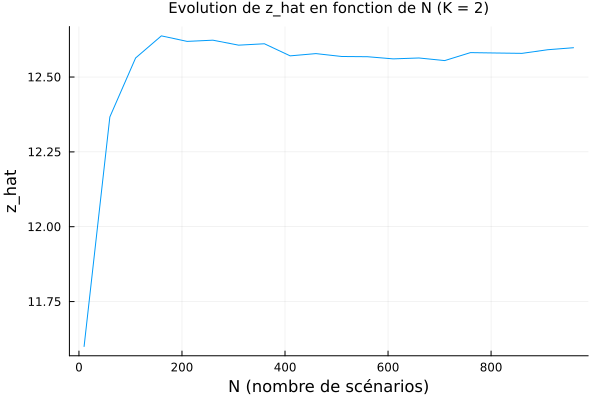

In [32]:
graph = load_graphs_from_dat(["KEP_031"])[1]
K = 2
B = 200

N_values = Array(10:50:1000)
logs = false

visualize_convergence(graph, B, logs,N_values, K)

<div style="text-align: center;">
    <img src="Images/conv_K_2.PNG" alt="Evolution de z_hat" style="max-width: 100%; height: auto;">
</div>

$$ \text{Evolution de } \hat z_N \text{ en fonction de N,  K = 2 (image du 31/01/2025)} $$ 

[■■■■■■■■■■■■■■■■■■■■] 10/10

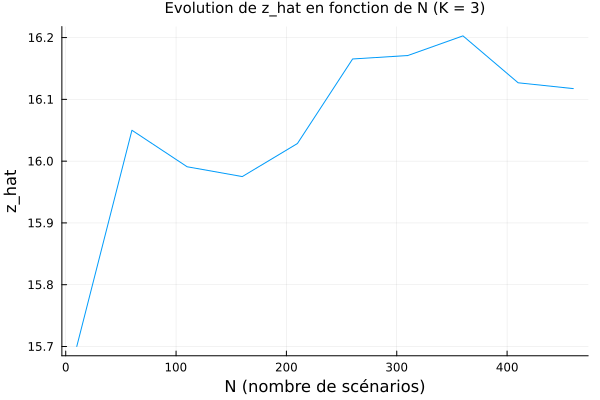

In [34]:
K = 3
N_values = Array(10:50:500)
logs = false

visualize_convergence(graph, B, logs, N_values, K)

<div style="text-align: center;">
    <img src="Images/conv_K_3.PNG" alt="Evolution de z_hat" style="max-width: 100%; height: auto;">
</div>

$$ \text{Evolution de } \hat z_N \text{ en fonction de N,  K = 3 (image du 31/01/2025)} $$ 

Comme la théorie le prévoyait, nous observons que les valeurs de $\hat{z_N}$ semblent bien converger à mesure que $N$ augmente. En effet, les valeurs de $\hat z_N$ semblent se stabiliser pour des grandes valeurs de $N$.

Ce premier test nous conforte donc sur la validité de nos implémentations.

**$\to$ Evolution de l'espérance de $\widehat z$**

Toujours d'après le cours, la valeur objectif du modèle d'optimisation devrait vérifier une certaine propriété. En effet, en notant $\hat{z}_N$ la valeur optimale du programme linéaire obtenue avec $N$ simulations, nous devrions observer que :
$$
\forall N \ge 0,~~\mathbb{E}[\hat z_{N+1} ] \le \mathbb{E}[\hat z_{N} ]
$$

Nous pouvons donc construire un test dans lequel nous résolvons le programme linéaire, pour des nombres de scénarios $N$ croissants. Pour chaque valeur de $N$, nous répétons la résolution sur $M$ simulations différentes, afin de construire une moyenne empirique de chaque $\hat z_N$. Si $M$ est assez grand, les moyennes empiriques pour des $N$ sucessifs devraient vérifier l'inégalité suivante : pour un $M$ donné, 
$$
\forall N \ge 0,~~\frac{1}{M} \sum_{i=1}^{M} \hat z^i_{N+1} \le \frac{1}{M} \sum_{i=1}^{M}\hat z^i_{N} 
$$


Nous proposons de réaliser ce test sur l'instance "KEP_031", avec $B = 64$, $M = 40$ et $N$ variant de 10 à 100.

[■■■■■■■■■■■■■■■■■■■■] 10/10

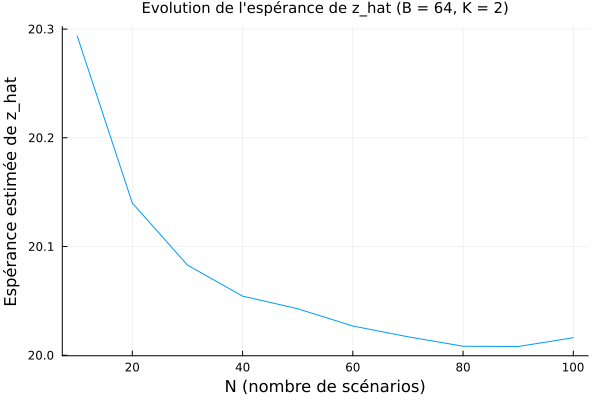

In [84]:
graph = load_graphs_from_dat(["KEP_031"])[1]

N_values = Array(10:10:100)
B = 64
M = 40
K = 2

evol_expectation(graph, B, M, N_values, K)

<div style="text-align: center;">
    <img src="Images/Expectation_2.PNG" alt="Evolution de l'espérance" style="max-width: 100%; height: auto;">
</div>

$$ \text{Evolution de l'espérance estimée - K = 2 (image du 17/01/2025)} $$ 

[■■■■■■■■■■■■■■■■■■■■] 10/10

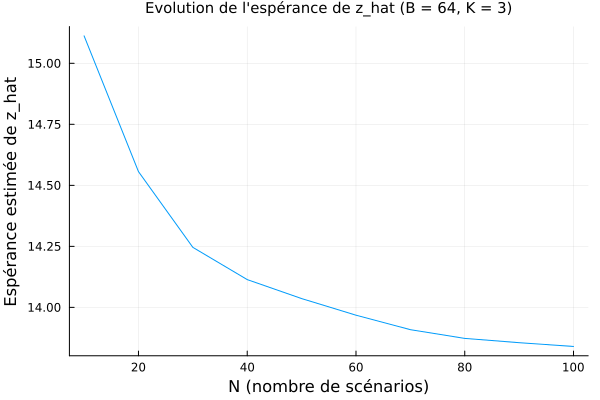

In [85]:
K = 3
evol_expectation(graph, B, M, N_values, K)

<div style="text-align: center;">
    <img src="Images/Expectation_3.PNG" alt="Evolution de l'espérance" style="max-width: 100%; height: auto;">
</div>

$$ \text{Evolution de l'espérance estimée - K = 3 (image du 17/01/2025)} $$ 

Dans les deux cas $K=2$ et $K=3$, l'inégalité semble être vérifiée. En effet, les moyennes empiriques des valeurs objectif des programmes linéaires sont décroissantes, sur la plage de test considérée.

Pour le cas $K=2$, nous observons toutefois une légère augmentation lors de la dernière itération, mais, l'échelle des ordonnées étant très faible, cette augmentation ne semble pas être significative. Le résultat étant empirique, avec une moyenne calculée sur 40 répétitions seulement, une petite anomalie de ce type pouvait en effet être prévisible.

**$\to$ Convergence des solutions**

Une autre propriété du cours indique que la solution optimale $\hat x_N$ d'une résolution avec $N$ scénarios (tests croisés à réaliser) converge vers la valeur optimale réelle du problème exact, lorsque $N$ tend vers l'infini. Ceci suggère que la distance entre chaque solution $\hat x$ successive diminue à mesure que $N$ augmente. C'est ce que nous allons tenter de vérifier dans cette partie.

Pour tenter de tester cette proposition, nous allons, pour des valeurs de $N$ croissantes, considérer la dernière solution $\hat x_{N_{max}}$ (celle associée au $N$ le plus grand) comme étant l'unique* solution optimale $x^*$. Nous comparerons ensuite les solutions à chaque étape avec celle-ci. L'idée étant que, si $N_{max}$ est assez grand, les solutions intermédiaires devraient se rapprocher de $\hat x_{N_{max}}$ à mesure que $N$ augmente. Pour comparer 2 solutions, nous calculerons la norme 1 de leur différence. Nous prendrons également une moyenne sur $M$ scénarios différents : 
$$
d(x^*,\hat x_N) \approx d(\hat x_{N_{max}},\hat x_N) = \frac{1}{M}.\sum_{i=1}^{M} \parallel  \hat x^i_{N_{max}} - \hat x^i_N \parallel _{_1  }
$$

En pratique, nous utiliserons l'instance "KEP_031", $M=10$, $B=64$ et $N$ variera entre 10 et 510.



*D'après le cours, la solution $x^*$ n'est pas nécessairement unique, et seule la convergence entre les espaces de solution est observée : 
$$
d_H(X^*,\hat X_N) \underset{N \to +\infty}{\overset{p.s.}{\to}} 0 ~~ \text{ ,  avec  }~~ d_H(A,B) = min \left\{  \underset{a \in A}{min}~~ d(a,B) ; \underset{b \in B}{min}~~ d(A,b) \right\}
$$
Ainsi, nous faisons une hypothèse assez forte dans ce test. Il est important de garder cette simplification en tête, et de nuancer le résultat qui en découle.


[■■■■■■■■■■■■■■■■■■■■] 11/11

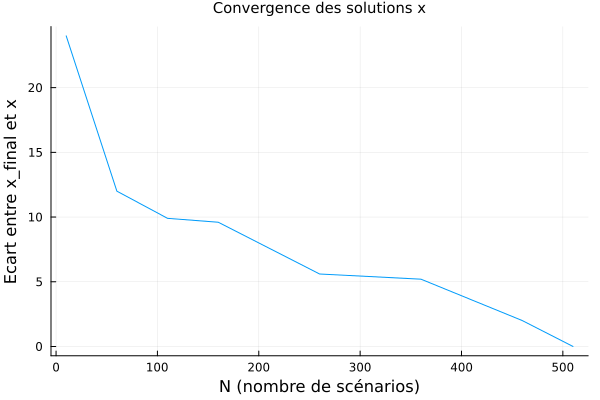

In [86]:
graph = load_graphs_from_dat(["KEP_031"])[1]

N = 510
N_values = Array(N:-50:10)
B = 64
M = 10
K = 2

x_convergence(graph, N_values, M, B, K)

<div style="text-align: center;">
    <img src="Images/convergence_x_2.PNG" style="max-width: 100%; height: auto;">
</div>

$$ \text{Convergence des solutions - K = 2 (image du 17/01/2025)} $$ 

[■■■■■■■■■■■■■■■■■■■■] 11/11

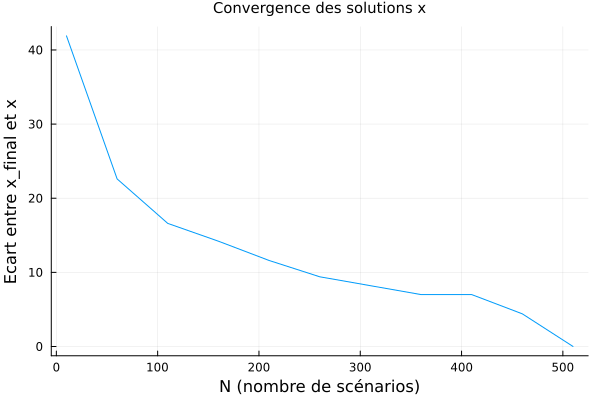

In [87]:
K = 3
x_convergence(graph, N_values, M, B, K)

<div style="text-align: center;">
    <img src="Images/convergence_x_3.PNG" style="max-width: 100%; height: auto;">
</div>

$$ \text{Convergence des solutions - K = 3 (image du 17/01/2025)} $$ 

Malgré l'hypothèses que nous avons faite, la distance entre chaque solution $\hat x_N$ et $\hat x_{N_{max}}$ semble diminuer à mesure que $N$ augmente. Ceci nous conforte vis-à-vis de la validité du résultat théorique, et donc de la validité de notre implémentation.

**$\to$ Comparaison avec les formulations compactes** 

Dans ce test, nous allons comparer la solution rendue par la formulation avec incertitudes dans le cas d'une distribution `"NoFailure"` avec la solution rendue sur le même graphe par la formulation compacte (établie dans la partie déterministe du projet). Nous simulerons donc un seul scénario avec la distribution `"NoFailure"` puisque cette distribution est déterministe, et nous l'utiliserons dans les formulations avec incertitudes et dans les formulations compactes de taille 2 et par hôpital (avec $K=3$).

- Pour $K = 2$, nous comparerons les valeurs objectif rendues par la formulation avec incertitudes et compacte sur les instances KEP_031, KEP_071 et KEP_111. 
- Pour $K = 3$, nous comparerons les valeurs objectif rendues par la formulation avec incertitudes et compacte sur les instances KEP_031 et KEP_071 (l'instance KEP_111 étant longue à résoudre).

Nous afficherons enfin, pour chaque valeur de $K$, le pourcentage de fois où les 2 formulations ont rendu le même résultat.

In [32]:
compare_compact()

Proportion de valeurs objectif égales pour K = 2 : 100.0 %
Proportion de valeurs objectif égales pour K = 3 : 100.0 %


On observe bel et bien que, dans le cas d'un problème déterministe, la résolution du problème de recours renvoie la même solution que les formulations compactes (ou en tout cas la même valeur objectif), ce qui est plutôt rassurant.

**$\to$ Comparaison K = 2 vs K = 3**

Pour finir cette partie sur le fonctionnement de nos formulations, nous allons comparer les valeurs objectif rendues avec des cycles de taille 2 et 3 sur les mêmes scénarios. Quelque soit le nombre de scénarios simulés $N$, nous devrions obtenir :
$$ \hat z_{K = 2} \le \hat z_{K = 3} $$

Nous allons vérifier cette inégalité sur les instances KEP_031 et KEP_071, avec $N=10$ scénarios.

Nous regarderons également si cette inégalité est vérifiée pour la solution "exacte" $\overline{z}$, i.e. la solution obtenue en résolvant le problème de recours sur un grand nombre de simulations avec les tests croisés $\hat x$ associés à $\hat z$.

In [29]:
N = 10
liste_graphs = ["KEP_031","KEP_071"]

compare_2_3(N, liste_graphs)

Graphe KEP_031 :
- z_hat(K=2) : 7.592               - z_barre(K=2) : 9.4
- z_hat(K=3) : 11.166              - z_barre(K=3) : 12.9
Graphe KEP_071 :
- z_hat(K=2) : 25.36               - z_barre(K=2) : 30.0
- z_hat(K=3) : 33.034              - z_barre(K=3) : 40.2
Proportion de cas où l'inégalité est respectée : 
   - Pour z_hat   : 100.0 %
   - Pour z_barre : 100.0 %


Tout d'abord, on observe que pour les deux instances, on a bien $\hat z_{K = 2} \le \hat z_{K = 3}$. Ce résultat nous conforte dans la validité de notre code puisqu'il doit être théoriquement vérifié.

On note de plus que l'inégalité $\overline z_{K = 2} \le \overline z_{K = 3}$ est également vérifiée pour les deux graphes. Ce résultat aurait pu ne pas être vérifié puisque les solution $\hat x$ avec lesquelles nous résolvons le recours ne sont que des estimations de $x^*$. Ainsi, en résolvant le recours avec ces valeurs sur de nouveaux scénarios, la valeur optimale obtenue aurait pu ne pas respecter l'inégalité. Toutefois ici, même avec seulement $N=10$ scénarios, le nombre espéré de transplantations $\overline z$ est plus grand pour $K=3$.

De plus, nous pouvons constater que le gap entre les solutions pour $K=2$ et $K=3$ est plus petit dans le cadre avec incertitudes que celui déterministe. En effet, pour l'instance KEP_031, dans le cas déterministe, le nombre de transplantation réalisées augmentait de 6 en passant de $K=2$ (16 greffes) à $K=3$ (22 greffes). Ici, l'écart entre $\overline z_{K = 2}$ et $\overline z_{K = 3}$ est seulement de 3,5. Ainsi, augmenter $K$ est bien moins utile dans le cadre incertain. Ceci justifie également notre choix de n'écrire des formulations que pour $K=2$ et $K=3$, puisque de toute façon, aller plus loin n'améliorerait pas significativement la solution.

#### 2 - Qualités de l'approche utilisée

Dans cette seconde partie dédiée aux tests des implémentations, nous souhaitons mettre en évidence l'intérêt d'utiliser l'approche par recours pour la résolution de ce problème. Pour cela, nous commencerons par comparer le nombre espéré de transplantation obtenu avec notre approche, au nombre obtenu de manière plus naïve : en résolvant le problème aux valeurs moyennes, ou en utilisant directement la méthode de génération de colonne.

**$\to$ Comparaison avec EV**

Nous commençons d'abord par comparer la valeur optimale rendue par le problème de recours avec la solution du problème aux valeurs moyennes. Ce problème revient à résoudre le problème de recours avec un seul scénario, correspondant à l'espérance des probabilités de réalisation des tests croisés. 

Formulation du problème aux valeurs moyennes pour $K=2$ : 
$$
(PVM) : 
\begin{aligned}
\max & \quad \sum_{s \in \mathcal{S}_N} \frac{1}{N} \left[ \sum_{c \in \mathcal{C}_K^2} 2.z_c(s) \right] \\
& \quad \sum_{(i,j) \in \mathcal{C}_K^2} 2.x_{(i,j)} \leq B \quad & (C_1) \\
& \quad \forall (i,j) \in \mathcal{C}_K^2, \forall s \in \mathcal{S}_N, \quad 
2 \cdot z_{(i,j)}(s) \le x_{(i,j)} \cdot (\mathbb{E}[\xi_{(i,j)}(s)] + \mathbb{E}[\xi_{(j,i)}(s)]) \quad & (C_2) \\
& \quad \forall s \in \mathcal{S}_N, \forall v \in V_2, \quad 
\sum_{c \in \mathcal{C}_2(v)} z_c(s) \leq 1 \quad & (C_3) \\
& \quad x_{(i,j)} \in \{0,1\}, \forall (i,j) \in \mathcal{C}_K^2; \\
& \quad z_c(s) \in [0,1], \forall s \in \mathcal{S}_N, \forall c \in \mathcal{C}_K^2.
\end{aligned}
$$

Pour ce problème, compte tenu de la contrainte $(C_2)$, nous devons relâcher la contrainte d'intégrité sur $z$. En effet, le membre de droite de l'inégalité est décimal, et compris entre 0 et 2. Ainsi, dans le cas où cette quantité est < 2, $z$ est contraint à prendre la valeur 0.

Pour faire ce test, nous allons traiter 2 graphes différents : "KEP_031" et "KEP_071". Pour chaque graphe considéré, nous allons résoudre le problème de recours, avec $N$ scénarios. Ensuite, nous réutiliserons la fonction ``uncertain_model_2`` (resp. ``uncertain_model_3``), avec un seul scénario "moyen". Ce scénario est représenté par la matrice des probabilité de faisabilité entre tous les couples possibles : 

$$
\mathbb{E}[\xi]_{(i,j)} = 1 - f_{(i,j)} \text{, où } f_{(i,j)} \text{ est la probabilité d'échec du test croisé entre } D_i \text{ et } M_j
$$

En notant $W$ la matrice des probabilité d'échec ($W_{(i,j)} = f_{(i,j)}$), le scénario moyen correspond à : 
$$
\mathbb{E}[\xi] = 1_{n \times n} - W
$$

Enfin, pour les deux solutions optimales $\hat x_N$ et $\hat x_{EV}$ obtenues en résolvant ces deux problèmes, nous calculerons la valeur optimale associée sur un grand nombre d'échantillon (environ $10.N$ scénarios).

In [27]:
graph_names = ["KEP_031","KEP_071"]
graphs = load_graphs_from_dat(graph_names)

B = [64,128]
N = [100,50]

K = 2
compare_EV(graphs, graph_names, B, N, K)

*** Graphe KEP_031 ***
 - Valeur optimale approchée (sous incertitudes) : 5.75
 - Valeur optimale approchée (expectation value) : 5.668
 - z* >= Z_EV ? true

Attention : time_limit atteint
Attention : time_limit atteint
*** Graphe KEP_071 ***
 - Valeur optimale approchée (sous incertitudes) : 25.38
 - Valeur optimale approchée (expectation value) : 24.616
 - z* >= Z_EV ? true

L'inégalité est vraie dans 100.0% des cas testés.


In [ ]:
K = 3
compare_EV(graphs, graph_names, B, N, K)

*** Graphe KEP_031 ***
 - Valeur optimale approchée (sous incertitudes) : 13.501
 - Valeur optimale approchée (expectation value) : 12.062
 - z* >= Z_EV ? true

Attention : time_limit atteint
Attention : time_limit atteint
*** Graphe KEP_071 ***
 - Valeur optimale approchée (sous incertitudes) : 35.226
 - Valeur optimale approchée (expectation value) : 30.991
 - z* >= Z_EV ? true

L'inégalité est vraie dans 100.0% des cas testés.


Sur les deux tests, nous pouvons voir que la méthode de recours s'avère être assez efficace, et semble proposer des tests croisés aboutissant à un nombre espéré de transplantations plus grand.

Pour l'instance "KEP_071", dans les deux cas, la résolution du problème de recours atteint la *time_limit* (fixée à 2000s pour réduire le temps de test). La valeur optimale rendue $\hat z_K$ est donc inférieure ou égale à la vraie valeur optimale $z^*$. Toutefois, même avec cette *time_limit*, le nombre espéré de transplantations reste supérieur à celui proposé par le problème aux valeurs moyennes. L'inégalité est donc nécessairement vérifiée pour la valeur optimale du problème.

Ce test montre l'intérêt de travailler avec un problème de recours plutôt qu'avec une implémentation plus "naïve", qui ne  considère que partiellement l'aspect incertain du problème.

**$\to$ Comparaison avec la génération de colonne simple**

Au delà de l'utilisation du problème aux valeurs moyennes, nous pouvons proposer une autre stratégie de choix des tests croisés. Nous pouvons appliquer l'algorithme de génération de colonne au graphe $\tilde G$, dont le poids de chaque arc correspond à la probabilité de réussite du test croisé ($= 1 - f_a$).

En l'appliquant une première fois, nous obtenons un ensemble d'arcs formant des cycles disjoints. En considérant que nous avons un certain budget $B$, nous pouvons rencontrer 2 possibilités :  
- Soit le nombre d'arcs rendu $nb\_arcs$ est $< B$ : on supprime ces arcs de $\tilde G$, et on recommence, en sachant que notre budget devient : $B \gets  B - \text{nb_arcs}$.
- Soit le nombre d'arcs rendu est $> B$ : on choisit alors les $B$ premiers arcs.

En itérant de cette manière, nous pouvons obtenir une liste de tests croisés à réaliser. Cette approche est bien entendu très naïve, puisqu'elle ne se base en rien sur l'incertitude du problème. En effet, ici, l'incertitude est simplement prise en compte au travers des probabilités de réussite de chaque test.

Une fois la liste des tests croisés obtenue, nous estimerons l'espérance du nombre de transplantation via la résolution du problème de recours avec $x$ fixé.

Nous allons écrire cette approche, et comparer les résultats à ceux obtenus avec les 2 approches précédentes : problème par recours et problème aux valeurs moyennes. Pour simplifier, nous travaillerons avec les instances "KEP_031" et "KEP_071", avec $K=2$.

In [121]:
graph_names = ["KEP_031","KEP_071"]
graphs = load_graphs_from_dat(graph_names)

B_values = [64,128]
N_values = [100,50]
K = 2

compare_gencol(graphs, graph_names, B_values, N_values, K)


Intance KEP_031 : 
     Méthode par génération de colonnes : 3.864
     Problème aux valeurs moyennes : 4.962
     Méthode avec recours : 6.6160000000000005

Intance KEP_071 : 
     Méthode par génération de colonnes : 10.81
     Problème aux valeurs moyennes : 16.802
     Méthode avec recours : 29.86


On observe ici que l'approche proposée en utilisant la génération de colonne pour sélectionner les tests croisés est nettement moins bonne que la formulation par recours, et moins bonne également que le problème aux valeurs moyennes.

Les 2 tests effectués ci-dessus confirment qu'utiliser la formulation avec recours, bien plus complexe et longue à résoudre (par rapport à EV notamment), a un réel intérêt puisque les résultats sont meilleurs : le nombre de transplantations espéré est plus grand qu'en utilisant une approche plus naïve. 

**$\to$ Impact du choix du budget $B$**

Durant les tests précédents, B a été fixé de manière arbitraire, en général en prenant $B=n$, le nombre de sommets du graphe.

Dans ce dernier test, nous allons essayer de voir si nous gagnerions quelque chose en récoltant plus d'information. En effet, dans un cadre opérationnel, nous nous donnons un certain budget pour les tests croisés. Toutefois, il semble important de se demander si, en modifiant légèrement ce budget, nous pourrions accroître de manière significative le nombre espéré de transplantations.

En particulier, nous pourrons observer si pour un budget donné nous sommes proches, ou assez éloignés, du nombre espéré de transplantation avec "information parfaite" (réalisation de tous les test croisés possibles).

D'un point de vue plus pratique, nous allons construire un graphique représentant l'évolution du nombre espéré de transplantations pour des valeurs croissantes de budget $B$, avec un nombre de scénarios $N$ constant.

[■■■■■■■■■■■■■■■■■■■■] 15/15

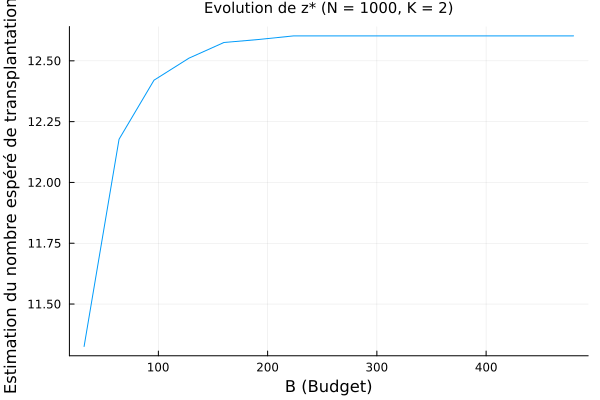

In [30]:
graph = load_graphs_from_dat(["KEP_031"])[1]

n = graph[1]
N = 1000

B_values = Array(n:n:length(graph[2]))
K = 2

compare_EVPI(graph, N, B_values, K)

<div style="text-align: center;">
    <img src="Images/evol_B_2.PNG" style="max-width: 100%; height: auto;">
</div>

$$ \text{Nombre espéré de transplantations en fonction de B - K = 2 (image du 29/01/2025)} $$ 

[■■■■■■■■■■■■■■■■■■■■] 15/15

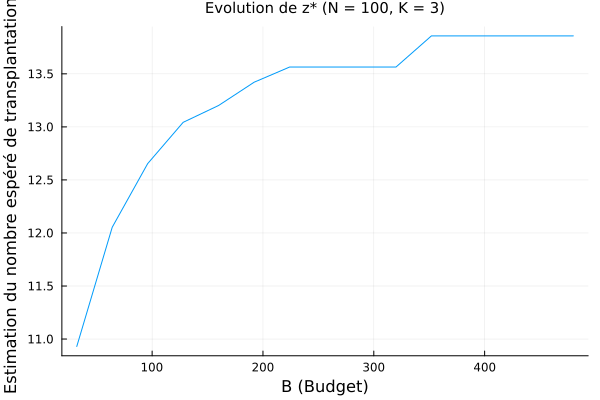

In [35]:
graph = load_graphs_from_dat(["KEP_031"])[1]

n = graph[1]
N = 100

B_values = Array(n:n:length(graph[2]))
K = 3
compare_EVPI(graph, N, B_values, K)

<div style="text-align: center;">
    <img src="Images/evol_B_3.PNG" style="max-width: 100%; height: auto;">
</div>

$$ \text{Nombre espéré de transplantations en fonction de B - K = 3 (image du 31/01/2025)} $$ 

Sur ces deux tests, nous pouvons voir que le budget semble fortement influer sur le nombre espéré de tests croisés. En effet, en augmentant le budget de quelques dizaines d'unités, la valeur optimale grandit assez rapidement. Toutefois, une fois un budget d'environ 200 tests atteint, la valeur optimale ne change plus de manière significative.

La valeur optimale avec information parfaite peut donc être obtenue avec un budget bien inférieur. Augmenter le budget semble donc être intéressant jusqu'à un certain stade. Ce graphique pourrait donc servir de base au choix du budget de tests. Toutefois, nous discuterons plus en détail de ce choix dans le cadre d'un autre test.

#### 3 - Analyse des choix de modélisation

Dans cette troisème partie, nous allons analyser les choix de modélisation effectués vis-à-vis de la formulation du problème ou de la création des graphes.

**$\to$ Choix de la distribution des probabilités d'échec**

Jusqu'à maintenant, nous avons utilisé une distribution binomiale lors de l'initialisation des graphes. Nous allons étudier la variation des résultats obtenus avec une distribution "BinomialAPD", prenant en compte le PRA du patient : on comparera $\overline z_{Binomial}$ avec $\overline z_{BinomialAPD}$ ainsi que les temps de résolution de notre formulation, et nous afficherons la proportion de tests croisés communs entre les deux distributions.

In [ ]:
N = 60
B = 40

graph_name = "KEP_031"
distrib_1 = "Binomial"
distrib_2 = "BinomialAPD"

compare_distrib(N,B,graph_name,distrib_1, distrib_2)

z_Binomial = 6.48
Attention : time_limit atteint
z_BinomialAPD = 13.690000000000001
Proportion de tests croisés communs : 15.0 %
Temps de résolution
  - Binomial : 0.087251 s
  - BinomialAPD : 400.1119022 s


On observe ici que la distribution "BinomialAPD" permet environ 7 transplantations de plus que la distribution "Binomial". On peut même penser que cette différence est en réalité encore plus grande puisque la résolution du problème avec la distribution "BinomialPRA" n'a pas convergé (la limite de temps était fixée à 400s).

Cette différence de valeur objectif s'explique par la différence entre les probabilités d'échec liées au deux distributions :
- dans le cas de la distribution binomiale, on attribue une probabilité d'éhec moyenne de 0.1 pour 25% des arcs et de 0.9 pour les 75% restants
- pour la distribution binomiale tenant compte de la PRA, on attribue une probabilité d'échec de 0.28 pour les arcs dont le PRA est < 0.75, et de 0.58 dans le cas contraire. Or, sur le graphe KEP_031, la grande majorité des arcs ont un PRA < 0.75. En moyenne, les arcs auront donc une probabilité d'échec plus faible pour cette distribution.

On peut le vérifier en générant un graphe avec chaque distribution et en calculant la moyenne des probabilités d'échec :

In [43]:
mat_Binom = load_graphs_from_dat(["KEP_031"])[1][3]
mat_APD = load_graphs_from_dat(["KEP_031"],"BinomialAPD")[1][3]

println("Binomial :")
println("  - moy_p_échec = ",mean(mat_Binom[mat_Binom .> 0.0]))
println("  - nombre d'incompatibilités = ",sum(1 .- mat_Binom .> 0.0))
println("\nBinomialAPD :")
println("  - moy_p_échec = ",mean(mat_APD[mat_APD .> 0.0]))
println("  - nombre d'incompatibilités = ",sum(1 .- mat_APD .> 0.0))

Binomial :
  - moy_p_échec = 0.7073848586625551
  - nombre d'incompatibilités = 1024

BinomialAPD :
  - moy_p_échec = 0.32497041420118344
  - nombre d'incompatibilités = 1024


En moyenne, les probabilités d'échec sont deux fois plus petites pour la distribution prenant en compte le PRA des patients. De ce fait, les tests croisés ont plus de chance de réussir donc l'espérance du nombre de transplantations possibles est plus grande avec cette distribution.

On voit également que la résolution du problème est bien plus longue avec la distribution APD : > 400s contre < 1s pour la distribution "Binomial". Cette différence peut être dûe au fait que les tests ont en moyenne plus de chance de réussir, les graphes simulés auront donc plus d'arcs, et il sera peut être plus difficile de sélectionner les meilleurs tests croisés à réaliser.

Enfin, la proportion de tests croisés communs entre les deux distributions est très faible, 15% ici. Ce résultat était prévisible puisque la répartition des probabilités d'échec est totalement différente entre les deux distributions. Les graphes résultants seront donc très différents, tout comme les simulations qui en résultent. De plus, la distribution binomiale attribue les probabilités de manière complètement aléatoire, ainsi, deux graphes générés avec une distribution binomiale sont aussi très différents. Nous pouvons vérifier cela en appelant notre fonction de test avec deux distributions binomiales :

In [ ]:
distrib_1 = "Binomial"
distrib_2 = "Binomial"

compare_distrib(N,B,graph_name,distrib_1, distrib_2)

z_Binomial = 7.0566666666666675
z_Binomial = 8.216666666666667
Proportion de tests croisés communs : 12.5 %
Temps de résolution
  - Binomial : 0.0513927 s
  - Binomial : 0.0516604 s


On observe bien ici aussi que la proportion de tests croisés en commun est très faible. Ce n'est donc pas une quantité que nous pouvons interpréter. En revanche, les deux valeurs optimales $\overline z$ restent, en général, assez proches.

En conclusion, la distribution utlisée pour modéliser le graphe impacte fortement la résolution du problème, tant au niveau de la solution que du temps d'exécution. Nous n'avons pas les connaissances nécessaires pour vraiment juger de la distribution la plus réaliste parmi toutes celles utilisables dans ce projet. Néanmoins, dans notre exemple, la distribution "BinomialAPD", qui semble être plus réaliste que la "Binomial" puisqu'elle tient compte du PRA des patients pour attribuer la probabilité d'échec, permet en moyenne de réaliser plus de greffes, mais prend aussi considérablement plus de temps à être résolue.

**$\to$ Tentative d'amélioration de notre PLNE**

Dans cette partie nous allons tenter d'améliorer le PLNE existant, en y ajoutant une nouvelle contrainte. 

Notre solution se base sur des scénarios. Ainsi, si un arc n'apparaît dans aucun cycle parmi les scénarios simulés, faire un test croisé entre les individus de cet arc serait inutile pour le modèle.

Nous allons donc construire un modèle ``uncertain_model_2_eff``, identique en tout point à ``uncertain_model_2``, avec une contrainte supplémentaire : 
$$
x_{(i,j)} \le \sum_{s \in S_N} z_{(i,j)}(s) ~~\forall (i,j) \in \mathcal{C}_K^2
$$

In [45]:
@nbinclude("Formulations_avec_incertitudes/Uncertain_Model_2_updated.ipynb")

Modèles modifiés importés avec succès.


In [50]:
# Test réalisé sur l'instance KEP_031
graph = load_graphs_from_dat(["KEP_031"])[1]

# Récupération des arcs et sommets du graphe restreint aux cycles de taille 2
C_2,V_2,C_v,A_2 = get_cycles_2(graph)
graph[2] = A_2
  
# Paramètres de la résolution
N = 100
B = 32

# Simulation des scénarios
S = simulate_scenarios(graph,N);

# Résolution de la formulation classique
obj,model,timer = uncertain_model_2(C_2,V_2,C_v, S, B,true)

# Affichage de la solution rendue
arcs = compute_solution_uncertain_2(model);
println("\n")

# Résolution de la solution augmentée de la contrainte
obj_eff,model_eff,timer_eff = uncertain_model_2_eff(C_2,V_2,C_v, S, B,true)
arcs_eff = compute_solution_uncertain_2(model_eff);

# Approximation du nombre espéré de transplantations
S_prime = simulate_scenarios(graph,10*N);
Obj, model, timer = pb_recours_2(C_2,V_2,C_v, S_prime, false, value.(model[:x]))
Obj_eff, model_eff, timer_eff = pb_recours_2(C_2,V_2,C_v, S_prime, false, value.(model_eff[:x]))

println("\nEstimation du nombre espéré de transplantations : ")
println("  - Modèle classique : ", Obj)
println("  - Modèle modifié : ", Obj_eff)

***** Uncertain *****
Statut de la solution = OPTIMAL
Valeur optimale = 9.96
Temps = 0.347971
***** Uncertain *****
Statut de la solution = OPTIMAL
Valeur optimale = 9.96
Temps = 0.4508769

Estimation du nombre espéré de transplantations : 
  - Modèle classique : 9.884
  - Modèle modifié : 9.884


Une première observation que nous pouvons faire est que les deux résolutions nous donnent exactement la même solution. Ceci est rassurant, puisque nous n'avons pas changé le modèle, et l'ajout de la contrainte ne devrait pas modifier la solution rendue par l'algorithme. Toutefois, le nombre espéré de transplantations $\overline{z_K}$ peut être légèrement différent, puisque la solution $\hat x_K$ n'est qu'une estimation de $x^*$.

Nous allons désormais comparer la vitesse d'exécution des deux formulations. Pour cela, nous nous baserons sur 2 instances : "KEP_031" et "KEP_071". Nous construirons plusieurs fois ces deux instances (avec des probabilités de failure différentes, ce qui nous permettra de comparer le temps d'exécution des deux modèles sur un grand nombre de tests.

Nous ne ferons cette comparaison que pour le cas $K=2$, avec $N=200,~B=32$ pour "KEP_031", et $N=100,~B=64$ pour "KEP_071".

[■■■■■■■■■■■■■■■■■■■■] 2/2
Pour l'instance KEP_031 : 
  - Formulation classique : 0.316s en moyenne
  - Formulation modifiée  : 0.346s en moyenne

 
Pour l'instance KEP_071 : 
  - Formulation classique : 2.657s en moyenne
  - Formulation modifiée  : 2.812s en moyenne


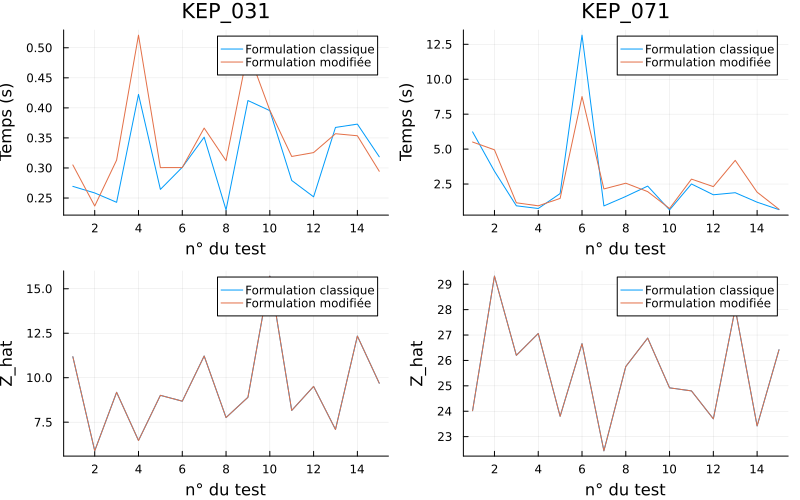

In [51]:
compare_formulation_eff()

<div style="text-align: center;">
    <img src="Images/Comp_contrainte_eff.PNG" style="max-width: 100%; height: auto;">
</div>

$$ \text{Comparaison des formulations - K = 2 (image du 23/01/2025)} $$ 

Comme nous pouvons le voir sur les graphiques ci-dessus, les deux formulations donnent bien les mêmes solutions optimales $\hat z_N$, ce qui est une bonne chose. Toutefois, nous n'observons pas de gain significatif en terme de temps de calcul. En effet, les temps de calcul restent très proches pour les deux formulations. Il semblerait même que la formulation classique propose un temps moyen légèrement plus faible, cette différence n'étant toutefois pas significativement grande.

Pour conclure quant à l'utilité de cette nouvelle contrainte, nous devrions peut être la tester sur d'autres instances, avec des valeurs de $N$ et $B$ différentes, voire même avec un $K$ différent. Le test étant déjà assez long pour les valeurs choisies, nous n'explorerons pas cet approfondissement.

**$\to$ Contrainte "éthique" sur les tests croisés**

Dans la partie déterministe, nous avions observé que certains individus pouvaient être écartés des cycles de dons. Du fait de leur faible nombre de liens avec les autres couples, certains malades étaient complètement ignorés par l'algorithme de génération de colonne. Est-ce la même chose pour les tests croisés à réaliser ?

Dans un premier temps, nous allons évaluer, sur plusieurs instances de test, la proportion d'individus n'apparaissant pas dans les tests croisés proposés (pour une valeur de $B$ donnée). Nous pourrons d'ailleurs analyser la variation de cette proportion lorsque $B$ augmente.

Ensuite, nous tenterons d'ajouter une contrainte dans la formulation avec cycles de taille 2 : 
$$
\sum_{a \in C_2(v)} x_a  \ge 1 ~~,~~\forall v \in V_2
$$

Cette contrainte nous oblige à accorder au minimum un test croisé par patient (et donc de n'en écarter aucun de l'étude menée).

[■■■■■■■■■■■■■■■■■■■■] 10/10



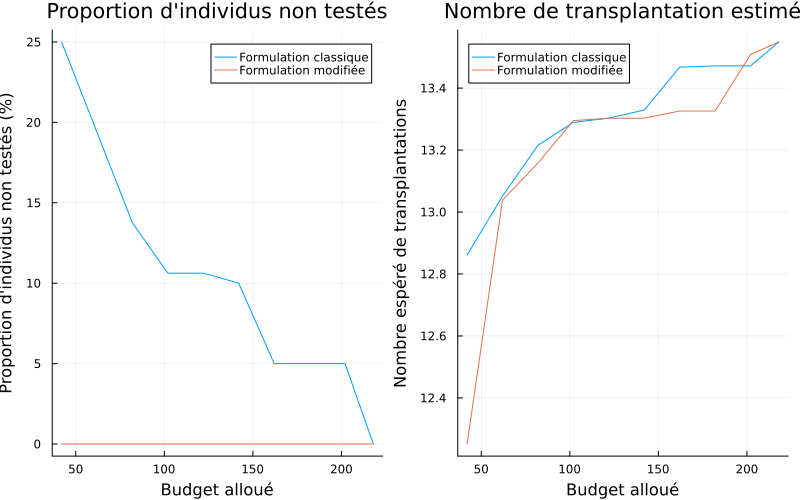

In [53]:
graph_name = "KEP_031"
compare_formulation_ethic(graph_name)

<div style="text-align: center;">
    <img src="Images/Compare_ethic.PNG" style="max-width: 100%; height: auto;">
</div>

$$ \text{Comparaison des formulations - K = 2 (image du 31/01/2025)} $$ 

Grâce au premier graphique, nous observons que notre contrainte est fonctionnelle puisque la proportion de sommets non testés est constante à 0% pour la formulation modifiée. Pour la formulation classique, on observe que la proportion d'individus non testés diminue à mesure que le budget augmente, ce qui est plutôt rassurant. Néanmoins, des paliers sont présents à certains endroits, ce qui signifie qu'augmenter légèrement le budget n'implique pas nécessairement plus de patients testés, mais plutôt une multiplication de tests pour un même individu.

Sur le deuxième graphe, on voit que la différence du nombre espéré de greffes est assez faible pour les deux formulations et semble diminuer à mesure que le budget augmente (ce qui est cohérent avec le fait que la proportion de sommets isolés dans la formulation classique diminue quand $B$ augmente). De plus, lorsque le budget est maximal (égal au nombre d'arcs du graphe - information parfaite), les deux formulations rendent la même solution, ce qui est également cohérent puisque tous les arcs sont testés dans les 2 cas.

A noter ici que la formulation avec la contrainte ajoutée est une restriction de la formulation classique. Ainsi, théoriquement, la valeur optimale du nouveau problème sera toujours plus petite que celle du problème de base. Les croisements observés sur le graphique de droite sont simplement liés au fait que nous résolvons le problème de recours avec une approximation $\hat x_N$ de $x^*$ : l'espérance réelle du nombre de transplantation ne devrait pas nous donner de chevauchements de ce type.

Ici pour le budget minimal, rajouter la contrainte fait perdre une transplantation. Dès que $B$ est supérieur à environ 60, la contrainte fait perdre moins de 0.5 transplantation. Ainsi peu importe le budget, la différence semble faible. Toutefois une question éthique se pose : pour $B=B_{min}$ par exemple, choisit-on de rajouter la contrainte pour donner une chance équitable à tout le monde, ou choisit-on de ne pas la mettre et "gagner" une transplantation, mais en ayant laissé des individus non testés, sans aucune chance d'être greffés ?

On pourrait peut-être imaginer, dans une situation réelle, résoudre les deux formulations (pour un budget donné), et faire notre choix en fonction de l'écart entre les deux nombres de transplantations obtenus. On pourrait aussi mener une étude en augmentant $B$ tel que nous l'avons fait, puis évaluer le budget à partir duquel rajouter la contrainte n'est pas trop désavantageux. Cette démarche nécessite néanmoins de fixer un seuil définissant *"pas trop désavantageux"*... Dans notre cas, à partir de $B=50$ on a déjà moins d'une transplantation d'écart, ce qui est très faible et pourrait légitimer le rajout de la contrainte.

## Conclusion

Cette seconde partie du projet nous a permis de prendre un recul certain sur la partie déterministe. En effet, à la suite de cette première partie, nos implémentations semblaient être bonnes, et assez réalistes pour être utilisées en pratique. La partie incertaine a toutefois complètement modifié notre perception du projet. La réalité étant bien plus compliquée que ce que suggérais la partie déterministe, un modèle plus complexe devait être considéré.

Au travers de plusieurs implémentations, nous avons pu aborder un problème d'optimisation sous incertitudes avec recours. Cet approfondissement a été l'occasion pour nous de relier 2 mondes : le monde de l'optimisation et le monde de la statistique.

Les tests de nos 2 méthodes de résolution nous ont d'une part permis de nous conforter quant à la validité de notre code, et d'autre part de développer davantage l'impact des hypothèses de ces modèles. Comme pour la partie déterministe, certains choix ont été discutés mais restent en suspens : le choix du budget, le choix de la distribution de probabilités et le choix du nombre de simulations en sont des exemples.

Au final, ce projet nous a offert une vision très large d'un projet, en apparence assez simple, mais qui pose des problèmes assez complexes en pratique. Et, comme évoqué lors de la conclusion intermédiaire, la partie "incertaine" nous a de nouveau offert une grande liberté dans nos choix d'implémentation, nous poussant à nous questionner et prendre du recul sur les objectifs du projet.

Pour conclure, l'articulation du module d'optimisation sous incertitudes autour d'un projet global sur le semestre entier a été très stimulante pour nous, et a été une grande source d'apprentissage.